## Imports

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

import tempfile
import random
import operator
import os
import sys
import gc
import git
from time import time
from functools import partial
from pathlib import Path

import datetime
import time
from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive, AutoETS

from utilsforecast.losses import mse, rmse, mae, mape, mase, smape, scaled_crps, msse
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend, fourier

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, ERM
from hierarchicalforecast.evaluation import evaluate
from hierarchicalforecast.utils import (
    aggregate,
    HierarchicalPlot,
    is_strictly_hierarchical,
    CodeTimer,
    aggregate_temporal,
    make_future_dataframe,
    get_cross_temporal_tags
)

from datasetsforecast.hierarchical import HierarchicalData, HierarchicalInfo
from datasetsforecast.m3 import M3

import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose 

In [2]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (14, 8)

# plt.style.use('ggplot')

## Quickstart

In [5]:
group_name = 'TourismSmall'
group = HierarchicalInfo.get_group(group_name)
Y_df, S_df, tags = HierarchicalData.load('./data', group_name)
S_df = S_df.reset_index(names="unique_id")
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [16]:
print(S_df.shape)
S_df.head()

(89, 57)


unique_id  nsw-hol-city  nsw-hol-noncity  vic-hol-city  vic-hol-noncity   
0     total           1.0              1.0           1.0              1.0  \
1       hol           1.0              1.0           1.0              1.0   
2       vfr           0.0              0.0           0.0              0.0   
3       bus           0.0              0.0           0.0              0.0   
4       oth           0.0              0.0           0.0              0.0   

   qld-hol-city  qld-hol-noncity  sa-hol-city  sa-hol-noncity  wa-hol-city   
0           1.0              1.0          1.0             1.0          1.0  \
1           1.0              1.0          1.0             1.0          1.0   
2           0.0              0.0          0.0             0.0          0.0   
3           0.0              0.0          0.0             0.0          0.0   
4           0.0              0.0          0.0             0.0          0.0   

   ...  qld-oth-city  qld-oth-noncity  sa-oth-city  sa-oth-noncity   
0  ...           1.0              1.0          1.0             1.0  \
1  ...           0.0              0.0          0.0             0.0   
2  ...           0.0              0.0          0.0             0.0   
3  ...           0.0              0.0          0.0             0.0   
4  ...           1.0              1.0          1.0             1.0   

   wa-oth-city  wa-oth-noncity  tas-oth-city  tas-oth-noncity  nt-oth-city   
0          1.0             1.0           1.0              1.0          1.0  \
1          0.0             0.0           0.0              0.0          0.0   
2          0.0             0.0           0.0              0.0          0.0   
3          0.0             0.0           0.0              0.0          0.0   
4          1.0             1.0           1.0              1.0          1.0   

   nt-oth-noncity  
0             1.0  
1             0.0  
2             0.0  
3             0.0  
4             1.0  

[5 rows x 57 columns]

In [17]:
print(Y_df.shape)
Y_df.head()

(3204, 3)


unique_id         ds      y
0     total 1998-03-31  84503
1     total 1998-06-30  65312
2     total 1998-09-30  72753
3     total 1998-12-31  70880
4     total 1999-03-31  86893

In [7]:
tags

{'Country': array(['total'], dtype=object),
 'Country/Purpose': array(['hol', 'vfr', 'bus', 'oth'], dtype=object),
 'Country/Purpose/State': array(['nsw-hol', 'vic-hol', 'qld-hol', 'sa-hol', 'wa-hol', 'tas-hol',
        'nt-hol', 'nsw-vfr', 'vic-vfr', 'qld-vfr', 'sa-vfr', 'wa-vfr',
        'tas-vfr', 'nt-vfr', 'nsw-bus', 'vic-bus', 'qld-bus', 'sa-bus',
        'wa-bus', 'tas-bus', 'nt-bus', 'nsw-oth', 'vic-oth', 'qld-oth',
        'sa-oth', 'wa-oth', 'tas-oth', 'nt-oth'], dtype=object),
 'Country/Purpose/State/CityNonCity': array(['nsw-hol-city', 'nsw-hol-noncity', 'vic-hol-city',
        'vic-hol-noncity', 'qld-hol-city', 'qld-hol-noncity',
        'sa-hol-city', 'sa-hol-noncity', 'wa-hol-city', 'wa-hol-noncity',
        'tas-hol-city', 'tas-hol-noncity', 'nt-hol-city', 'nt-hol-noncity',
        'nsw-vfr-city', 'nsw-vfr-noncity', 'vic-vfr-city',
        'vic-vfr-noncity', 'qld-vfr-city', 'qld-vfr-noncity',
        'sa-vfr-city', 'sa-vfr-noncity', 'wa-vfr-city', 'wa-vfr-noncity',
     

In [8]:
Y_test_df = Y_df.groupby('unique_id').tail(group.horizon)
Y_train_df = Y_df.drop(Y_test_df.index)

Basic forecasts

In [30]:
fcst = StatsForecast(
    models=[AutoARIMA(season_length=group.seasonality), Naive()], 
    freq="1q", 
    n_jobs=-1
)
Y_hat_df = fcst.forecast(df=Y_train_df, h=group.horizon)

Hierarchical reconcilation

In [32]:
reconcilers = [
    BottomUp(),
    TopDown(method='forecast_proportions'),
    TopDown(method='proportion_averages'),
    MiddleOut(middle_level="Country/Purpose/State", top_down_method="proportion_averages"),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df, S=S_df, tags=tags)

Evaluation

In [34]:
df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'])
evaluation = evaluate(df = df,
                      tags = tags,
                      train_df = Y_train_df,
                      metrics = [mse],
                      benchmark="Naive")

evaluation.set_index(["level", "metric"]).filter(like="ARIMA", axis=1)

AutoARIMA  AutoARIMA/BottomUp   
level                             metric                                      
Country                           mse-scaled   0.123161            0.055251  \
Country/Purpose                   mse-scaled   0.171062            0.077679   
Country/Purpose/State             mse-scaled   0.194383            0.149161   
Country/Purpose/State/CityNonCity mse-scaled   0.170372            0.170372   
Overall                           mse-scaled   0.154911            0.085333   

                                              AutoARIMA/TopDown_method-forecast_proportions   
level                             metric                                                      
Country                           mse-scaled                                       0.123161  \
Country/Purpose                   mse-scaled                                       0.101570   
Country/Purpose/State             mse-scaled                                       0.201738   
Country/Purpose/State/CityNonCity mse-scaled                                       0.210060   
Overall                           mse-scaled                                       0.131308   

                                              AutoARIMA/TopDown_method-proportion_averages   
level                             metric                                                     
Country                           mse-scaled                                      0.123161  \
Country/Purpose                   mse-scaled                                      0.128151   
Country/Purpose/State             mse-scaled                                      0.327854   
Country/Purpose/State/CityNonCity mse-scaled                                      0.341365   
Overall                           mse-scaled                                      0.168269   

                                              AutoARIMA/MiddleOut_middle_level-Country/Purpose/State_top_down_method-proportion_averages  
level                             metric                                                                                                  
Country                           mse-scaled                                           0.079279                                           
Country/Purpose                   mse-scaled                                           0.104186                                           
Country/Purpose/State             mse-scaled                                           0.194383                                           
Country/Purpose/State/CityNonCity mse-scaled                                           0.225655                                           
Overall                           mse-scaled                                           0.115569

## Introduction

**1. Hierarchical Series**  
In many applications, a set of time series is hierarchically organized. Examples include the presence of geographic levels, products, or categories that define different types of aggregations.

In such scenarios, forecasters are often required to provide predictions for all disaggregate and aggregate series. A natural desire is for those predictions to be “coherent”, that is, for the bottom series to add up precisely to the forecasts of the aggregated series.

The above figure shows a simple hierarchical structure where we have four bottom-level series, two middle-level series, and the top level representing the total aggregation. Its hierarchical aggregations or coherency constraints are:

$$
y_{\text{Total}, \tau} = y_{\beta_1, \tau} + y_{\beta_2, \tau} + y_{\beta_3, \tau} + y_{\beta_4, \tau}
$$

$$
y_{[a], \tau} = \begin{bmatrix}
y_{\text{Total}, \tau}, \quad y_{\beta_1, \tau} + y_{\beta_2, \tau}, \quad y_{\beta_3, \tau} + y_{\beta_4, \tau}
\end{bmatrix}^\top
$$

$$
y_{[b], \tau} = \begin{bmatrix}
y_{\beta_1, \tau}, \quad y_{\beta_2, \tau}, \quad y_{\beta_3, \tau}, \quad y_{\beta_4, \tau}
\end{bmatrix}^\top
$$

Luckily these constraints can be compactly expressed with the following matrices:

$$
S_{[a,b][b]} = 
\begin{bmatrix}
A_{[a][b]} \\ I_{[b][b]}
\end{bmatrix} = 
\begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & 1 & 0 & 0 \\
0 & 0 & 1 & 1 \\
\hline
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

where $A_{[a,b][b]}$ aggregates the bottom series to the upper levels, and $I_{[b][b]}$ is an identity matrix. The representation of the hierarchical series is then:

$$
y_{[a,b], \tau} = S_{[a,b][b]} y_{[b], \tau}
$$

To visualize an example, in Figure 2, one can think of the hierarchical time series structure levels to represent different geographical aggregations. For example, in Figure 2, the top level is the total aggregation of series within a country, the middle level being its states and the bottom level its regions.

---

**2. Hierarchical Forecast**  
To achieve “coherency”, most statistical solutions to the hierarchical forecasting challenge implement a two-stage reconciliation process.

1. First, we obtain a set of the base forecast $\hat{y}_{[a,b], \tau}$

2. Later, we reconcile them into coherent forecasts $\tilde{y}_{[a,b], \tau}$

Most hierarchical reconciliation methods can be expressed by the following transformations:

$$
\tilde{y}_{[a,b], \tau} = S_{[a,b][b]} P_{[b][a,b]} \hat{y}_{[a,b], \tau}
$$

The **HierarchicalForecast** library offers a Python collection of reconciliation methods, datasets, evaluation and visualization tools for the task. Among its available reconciliation methods we have **BottomUp**, **TopDown**, **MiddleOut**, **MinTrace**, **ERM**. Among its probabilistic coherent methods we have **Normality**, **Bootstrap**, **PERMBU**.


Minimal example

In [35]:
ds = pd.date_range(start='2000-01-01', end='2000-08-01', freq='MS')
y_base = np.arange(1,9)
r1 = y_base * (10**1)
r2 = y_base * (10**1)
r3 = y_base * (10**2)
r4 = y_base * (10**2)

ys = np.concatenate([r1, r2, r3, r4])
ds = np.tile(ds, 4)
unique_ids = ['r1'] * 8 + ['r2'] * 8 + ['r3'] * 8 + ['r4'] * 8
top_level = 'Australia'
middle_level = ['State1'] * 16 + ['State2'] * 16
bottom_level = unique_ids

bottom_df = dict(ds=ds,
                 top_level=top_level, 
                 middle_level=middle_level, 
                 bottom_level=bottom_level,
                 y=ys)
bottom_df = pd.DataFrame(bottom_df)
bottom_df.groupby('bottom_level').head(2)

ds  top_level middle_level bottom_level    y
0  2000-01-01  Australia       State1           r1   10
1  2000-02-01  Australia       State1           r1   20
8  2000-01-01  Australia       State1           r2   10
9  2000-02-01  Australia       State1           r2   20
16 2000-01-01  Australia       State2           r3  100
17 2000-02-01  Australia       State2           r3  200
24 2000-01-01  Australia       State2           r4  100
25 2000-02-01  Australia       State2           r4  200

In [37]:
# Create hierarchical structure and constraints
hierarchy_levels = [['top_level'],
                    ['top_level', 'middle_level'],
                    ['top_level', 'middle_level', 'bottom_level']]
Y_hier_df, S_df, tags = aggregate(df=bottom_df, spec=hierarchy_levels)
print('S_df.shape', S_df.shape)
print('Y_hier_df.shape', Y_hier_df.shape)
print("tags['top_level']", tags['top_level'])

S_df.shape (7, 5)
Y_hier_df.shape (56, 3)
tags['top_level'] ['Australia']


In [38]:
Y_hier_df.groupby('unique_id').head(2)


unique_id         ds    y
0             Australia 2000-01-01  220
1             Australia 2000-02-01  440
8      Australia/State1 2000-01-01   20
9      Australia/State1 2000-02-01   40
16     Australia/State2 2000-01-01  200
17     Australia/State2 2000-02-01  400
24  Australia/State1/r1 2000-01-01   10
25  Australia/State1/r1 2000-02-01   20
32  Australia/State1/r2 2000-01-01   10
33  Australia/State1/r2 2000-02-01   20
40  Australia/State2/r3 2000-01-01  100
41  Australia/State2/r3 2000-02-01  200
48  Australia/State2/r4 2000-01-01  100
49  Australia/State2/r4 2000-02-01  200

In [39]:
S_df

unique_id  Australia/State1/r1  Australia/State1/r2   
0            Australia                  1.0                  1.0  \
1     Australia/State1                  1.0                  1.0   
2     Australia/State2                  0.0                  0.0   
3  Australia/State1/r1                  1.0                  0.0   
4  Australia/State1/r2                  0.0                  1.0   
5  Australia/State2/r3                  0.0                  0.0   
6  Australia/State2/r4                  0.0                  0.0   

   Australia/State2/r3  Australia/State2/r4  
0                  1.0                  1.0  
1                  0.0                  0.0  
2                  1.0                  1.0  
3                  0.0                  0.0  
4                  0.0                  0.0  
5                  1.0                  0.0  
6                  0.0                  1.0

In [40]:
# Split train/test sets
Y_test_df  = Y_hier_df.groupby('unique_id', as_index=False).tail(4)
Y_train_df = Y_hier_df.drop(Y_test_df.index)

# Compute base Naive predictions
# Careful identifying correct data freq, this data monthly 'M'
fcst = StatsForecast(models=[Naive()],
                     freq='MS', n_jobs=-1)
Y_hat_df = fcst.forecast(df=Y_train_df, h=4, fitted=True)
Y_fitted_df = fcst.forecast_fitted_values()

In [41]:
reconcilers = [BottomUp()] # MinTrace(method='mint_shrink')
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, 
                          Y_df=Y_fitted_df,
                          S=S_df, tags=tags)
Y_rec_df.groupby('unique_id').head(2)

unique_id         ds  Naive  Naive/BottomUp
0             Australia 2000-05-01  880.0           880.0
1             Australia 2000-06-01  880.0           880.0
4      Australia/State1 2000-05-01   80.0            80.0
5      Australia/State1 2000-06-01   80.0            80.0
8      Australia/State2 2000-05-01  800.0           800.0
9      Australia/State2 2000-06-01  800.0           800.0
12  Australia/State1/r1 2000-05-01   40.0            40.0
13  Australia/State1/r1 2000-06-01   40.0            40.0
16  Australia/State1/r2 2000-05-01   40.0            40.0
17  Australia/State1/r2 2000-06-01   40.0            40.0
20  Australia/State2/r3 2000-05-01  400.0           400.0
21  Australia/State2/r3 2000-06-01  400.0           400.0
24  Australia/State2/r4 2000-05-01  400.0           400.0
25  Australia/State2/r4 2000-06-01  400.0           400.0

## Point reconcilation

### Geographical aggregation (Tourism)

EDA

In [43]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.PeriodIndex(Y_df["ds"], freq='Q').to_timestamp()
Y_df.head()

Country    Region            State   Purpose         ds           y
0  Australia  Adelaide  South Australia  Business 1998-01-01  135.077690
1  Australia  Adelaide  South Australia  Business 1998-04-01  109.987316
2  Australia  Adelaide  South Australia  Business 1998-07-01  166.034687
3  Australia  Adelaide  South Australia  Business 1998-10-01  127.160464
4  Australia  Adelaide  South Australia  Business 1999-01-01  137.448533

In [44]:
spec = [
    ['Country'],
    ['Country', 'State'], 
    ['Country', 'Purpose'], 
    ['Country', 'State', 'Region'], 
    ['Country', 'State', 'Purpose'], 
    ['Country', 'State', 'Region', 'Purpose']
]

In [45]:
Y_df, S_df, tags = aggregate(Y_df, spec)

In [46]:
print(Y_df.shape)
Y_df.head()

(34000, 3)


unique_id         ds             y
0  Australia 1998-01-01  23182.197269
1  Australia 1998-04-01  20323.380067
2  Australia 1998-07-01  19826.640511
3  Australia 1998-10-01  20830.129891
4  Australia 1999-01-01  22087.353380

In [48]:
S_df

unique_id   
0                                            Australia  \
1                                        Australia/ACT   
2                            Australia/New South Wales   
3                         Australia/Northern Territory   
4                                 Australia/Queensland   
..                                                 ...   
420  Australia/Western Australia/Australia's South ...   
421  Australia/Western Australia/Experience Perth/B...   
422  Australia/Western Australia/Experience Perth/H...   
423  Australia/Western Australia/Experience Perth/O...   
424  Australia/Western Australia/Experience Perth/V...   

     Australia/ACT/Canberra/Business  Australia/ACT/Canberra/Holiday   
0                                1.0                             1.0  \
1                                1.0                             1.0   
2                                0.0                             0.0   
3                                0.0                             0.0   
4                                0.0                             0.0   
..                               ...                             ...   
420                              0.0                             0.0   
421                              0.0                             0.0   
422                              0.0                             0.0   
423                              0.0                             0.0   
424                              0.0                             0.0   

     Australia/ACT/Canberra/Other  Australia/ACT/Canberra/Visiting   
0                             1.0                              1.0  \
1                             1.0                              1.0   
2                             0.0                              0.0   
3                             0.0                              0.0   
4                             0.0                              0.0   
..                            ...                              ...   
420                           0.0                              0.0   
421                           0.0                              0.0   
422                           0.0                              0.0   
423                           0.0                              0.0   
424                           0.0                              0.0   

     Australia/New South Wales/Blue Mountains/Business   
0                                                  1.0  \
1                                                  0.0   
2                                                  1.0   
3                                                  0.0   
4                                                  0.0   
..                                                 ...   
420                                                0.0   
421                                                0.0   
422                                                0.0   
423                                                0.0   
424                                                0.0   

     Australia/New South Wales/Blue Mountains/Holiday   
0                                                 1.0  \
1                                                 0.0   
2                                                 1.0   
3                                                 0.0   
4                                                 0.0   
..                                                ...   
420                                               0.0   
421                                               0.0   
422                                               0.0   
423                                               0.0   
424                                               0.0   

     Australia/New South Wales/Blue Mountains/Other   
0                                               1.0  \
1                                               0.0   
2                                               1.0   
3                                       

In [49]:
tags['Country/Purpose']

array(['Australia/Business', 'Australia/Holiday', 'Australia/Other',
       'Australia/Visiting'], dtype=object)

Train-test split

In [50]:
Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

In [51]:
Y_train_df.groupby('unique_id').size()

unique_id
Australia                                                72
Australia/ACT                                            72
Australia/ACT/Business                                   72
Australia/ACT/Canberra                                   72
Australia/ACT/Canberra/Business                          72
                                                         ..
Australia/Western Australia/Experience Perth/Other       72
Australia/Western Australia/Experience Perth/Visiting    72
Australia/Western Australia/Holiday                      72
Australia/Western Australia/Other                        72
Australia/Western Australia/Visiting                     72
Length: 425, dtype: int64

Base forecasts

In [54]:
fcst = StatsForecast(models=[AutoETS(season_length=4, model='ZZA')], 
                     freq='QS', n_jobs=-1)
Y_hat_df = fcst.forecast(df=Y_train_df, h=8, fitted=True)
Y_fitted_df = fcst.forecast_fitted_values()

Reconcile forecasts

In [57]:
reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df, tags=tags)

In [58]:
Y_rec_df.head()

unique_id         ds       AutoETS  AutoETS/BottomUp   
0  Australia 2016-01-01  25990.068004      24381.672902  \
1  Australia 2016-04-01  24458.490282      22903.194017   
2  Australia 2016-07-01  23974.055984      22411.401317   
3  Australia 2016-10-01  24563.454495      23127.009693   
4  Australia 2017-01-01  25990.068004      24518.047369   

   AutoETS/MinTrace_method-mint_shrink  AutoETS/MinTrace_method-ols  
0                         25427.793552                 25894.419896  
1                         23913.800915                 24357.231461  
2                         23428.540858                 23865.928094  
3                         24089.585591                 24470.780870  
4                         25545.039186                 25901.383310

Evaluation

In [62]:
eval_tags = {}
eval_tags['Total'] = tags['Country']
eval_tags['Purpose'] = tags['Country/Purpose']
eval_tags['State'] = tags['Country/State']
eval_tags['Regions'] = tags['Country/State/Region']
eval_tags['Bottom'] = tags['Country/State/Region/Purpose']

df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'])
evaluation = evaluate(df = df,
                      tags = eval_tags,
                      train_df = Y_train_df,
                      metrics = [rmse,
                                 partial(mase, seasonality=4)])

evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].apply(lambda x: round(x, 2))

In [64]:
evaluation.query('metric == "rmse"')

level metric     Base  BottomUp  MinTrace(mint_shrink)  MinTrace(ols)
0     Total   rmse  1743.29   3029.02                2112.94        1818.94
2   Purpose   rmse   534.75    791.28                 577.18         515.53
4     State   rmse   308.15    413.44                 316.85         287.34
6   Regions   rmse    51.66     55.13                  46.55          46.29
8    Bottom   rmse    19.37     19.37                  17.80          18.19
10  Overall   rmse    41.13     49.82                  40.47          38.75

In [65]:
evaluation.query('metric == "mase"')

level metric  Base  BottomUp  MinTrace(mint_shrink)  MinTrace(ols)
1     Total   mase  1.59      3.16                   2.06           1.67
3   Purpose   mase  1.32      2.28                   1.48           1.25
5     State   mase  1.39      1.90                   1.40           1.25
7   Regions   mase  1.12      1.19                   1.01           0.99
9    Bottom   mase  0.98      0.98                   0.94           1.01
11  Overall   mase  1.02      1.06                   0.97           1.02

### Non-negative MinTrace

Load data

In [66]:
Y_df, S_df, tags = HierarchicalData.load('./data', 'Wiki2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
S_df = S_df.reset_index(names="unique_id")

In [67]:
Y_df.head()

unique_id         ds       y
0     Total 2016-01-01  156508
1     Total 2016-01-02  129902
2     Total 2016-01-03  138203
3     Total 2016-01-04  115017
4     Total 2016-01-05  126042

In [68]:
S_df

unique_id  de_AAC_AAG_001  de_AAC_AAG_010  de_AAC_AAG_014   
0             Total               1               1               1  \
1                de               1               1               1   
2                en               0               0               0   
3                fr               0               0               0   
4                ja               0               0               0   
..              ...             ...             ...             ...   
194  zh_MOB_AAG_005               0               0               0   
195  zh_MOB_AAG_028               0               0               0   
196  zh_MOB_AAG_031               0               0               0   
197  zh_MOB_AAG_036               0               0               0   
198  zh_MOB_AAG_138               0               0               0   

     de_AAC_AAG_045  de_AAC_AAG_063  de_AAC_AAG_100  de_AAC_AAG_110   
0                 1               1               1               1  \
1                 1               1               1               1   
2                 0               0               0               0   
3                 0               0               0               0   
4                 0               0               0               0   
..              ...             ...             ...             ...   
194               0               0               0               0   
195               0               0               0               0   
196               0               0               0               0   
197               0               0               0               0   
198               0               0               0               0   

     de_AAC_AAG_123  de_AAC_AAG_143  ...  zh_DES_AAG_054  zh_DES_AAG_056   
0                 1               1  ...               1               1  \
1                 1               1  ...               0               0   
2                 0               0  ...               0               0   
3                 0               0  ...               0               0   
4                 0               0  ...               0               0   
..              ...             ...  ...             ...             ...   
194               0               0  ...               0               0   
195               0               0  ...               0               0   
196               0               0  ...               0               0   
197               0               0  ...               0               0   
198               0               0  ...               0               0   

     zh_DES_AAG_068  zh_DES_AAG_089  zh_DES_AAG_139  zh_MOB_AAG_005   
0                 1               1               1               1  \
1                 0               0               0               0   
2                 0               0               0               0   
3                 0               0               0               0   
4                 0               0               0               0   
..              ...             ...             ...             ...   
194               0               0               0               1   
195               0               0               0               0   
196               0               0               0               0   
197               0               0               0               0   
198               0               0               0               0   

     zh_MOB_AAG_028  zh_MOB_AAG_031  zh_MOB_AAG_036  zh_MOB_AAG_138  
0                 1               1               1               1  
1                 0               0               0               0  
2                 0               0               0               0  
3                 0               0               0               0  
4                 0               0               0               0  
..              ...             ...             ...             ...  
194               0               0             

In [69]:
tags

{'Views': array(['Total'], dtype=object),
 'Views/Country': array(['de', 'en', 'fr', 'ja', 'ru', 'zh'], dtype=object),
 'Views/Country/Access': array(['de_AAC', 'de_DES', 'de_MOB', 'en_AAC', 'en_DES', 'en_MOB',
        'fr_AAC', 'fr_DES', 'fr_MOB', 'ja_AAC', 'ja_DES', 'ja_MOB',
        'ru_AAC', 'ru_DES', 'ru_MOB', 'zh_AAC', 'zh_DES', 'zh_MOB'],
       dtype=object),
 'Views/Country/Access/Agent': array(['de_AAC_AAG', 'de_AAC_SPD', 'de_DES_AAG', 'de_MOB_AAG',
        'en_AAC_AAG', 'en_AAC_SPD', 'en_DES_AAG', 'en_MOB_AAG',
        'fr_AAC_AAG', 'fr_AAC_SPD', 'fr_DES_AAG', 'fr_MOB_AAG',
        'ja_AAC_AAG', 'ja_AAC_SPD', 'ja_DES_AAG', 'ja_MOB_AAG',
        'ru_AAC_AAG', 'ru_AAC_SPD', 'ru_DES_AAG', 'ru_MOB_AAG',
        'zh_AAC_AAG', 'zh_AAC_SPD', 'zh_DES_AAG', 'zh_MOB_AAG'],
       dtype=object),
 'Views/Country/Access/Agent/Topic': array(['de_AAC_AAG_001', 'de_AAC_AAG_010', 'de_AAC_AAG_014',
        'de_AAC_AAG_045', 'de_AAC_AAG_063', 'de_AAC_AAG_100',
        'de_AAC_AAG_110', 'de_AAC

In [70]:
Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(7)
Y_train_df = Y_df.drop(Y_test_df.index)

base forecasts

In [71]:
fcst = StatsForecast(
    models=[AutoETS(season_length=7, model='ZAA'), Naive()], 
    freq='D', 
    n_jobs=-1
)
Y_hat_df = fcst.forecast(df=Y_train_df, h=7)
Y_hat_df.query('AutoETS < 0')


unique_id         ds     AutoETS   Naive
28    de_AAC_AAG_001 2016-12-25 -523.766907   340.0
29    de_AAC_AAG_001 2016-12-26 -245.337433   340.0
30    de_AAC_AAG_001 2016-12-27 -194.253815   340.0
33    de_AAC_AAG_001 2016-12-30 -315.425659   340.0
34    de_AAC_AAG_001 2016-12-31 -806.920105   340.0
...              ...        ...         ...     ...
1217  zh_AAC_AAG_033 2016-12-31  -86.466789    37.0
1345          zh_MOB 2016-12-26 -199.534882  1036.0
1346          zh_MOB 2016-12-27  -69.527260  1036.0
1352      zh_MOB_AAG 2016-12-26 -199.534882  1036.0
1353      zh_MOB_AAG 2016-12-27  -69.527260  1036.0

[101 rows x 4 columns]

Non-Negative Reconciliation

In [72]:
reconcilers = [
    MinTrace(method='ols'),
    MinTrace(method='ols', nonnegative=True)
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df,
                          S=S_df, tags=tags)

/home/eduard/mambaforge/envs/mix/lib/python3.9/site-packages/hierarchicalforecast/methods.py:1121: UserWarning: Replacing negative forecasts with zero.
  warnings.warn("Replacing negative forecasts with zero.")


In [73]:
Y_rec_df

unique_id         ds        AutoETS    Naive   
0              Total 2016-12-25   94523.164062  95743.0  \
1              Total 2016-12-26   87734.367188  95743.0   
2              Total 2016-12-27   87751.125000  95743.0   
3              Total 2016-12-28  133237.968750  95743.0   
4              Total 2016-12-29  126501.796875  95743.0   
...              ...        ...            ...      ...   
1388  zh_MOB_AAG_138 2016-12-27      62.049744     65.0   
1389  zh_MOB_AAG_138 2016-12-28      54.934032     65.0   
1390  zh_MOB_AAG_138 2016-12-29      60.452618     65.0   
1391  zh_MOB_AAG_138 2016-12-30      50.356693     65.0   
1392  zh_MOB_AAG_138 2016-12-31      66.735626     65.0   

      AutoETS/MinTrace_method-ols  Naive/MinTrace_method-ols   
0                    95852.072700                    95743.0  \
1                    89525.240525                    95743.0   
2                    89638.150957                    95743.0   
3                   131051.617637                    95743.0   
4                   121214.073705                    95743.0   
...                           ...                        ...   
1388                  -147.400900                       65.0   
1389                     7.569633                       65.0   
1390                   114.252588                       65.0   
1391                    96.447770                       65.0   
1392                   208.195675                       65.0   

      AutoETS/MinTrace_method-ols_nonnegative-True   
0                                     96642.508994  \
1                                     90288.571623   
2                                     90565.961736   
3                                    131402.619556   
4                                    121800.000345   
...                                            ...   
1388                                      0.000000   
1389                                      0.000000   
1390                                     93.212883   
1391                                     75.652748   
1392                                    185.124512   

      Naive/MinTrace_method-ols_nonnegative-True  
0                                        95743.0  
1                                        95743.0  
2                                        95743.0  
3                                        95743.0  
4                                        95743.0  
...                                          ...  
1388                                        65.0  
1389                                        65.0  
1390                                        65.0  
1391                                        65.0  
1392                                        65.0  

[1393 rows x 8 columns]

In [74]:
Y_rec_df.query('`AutoETS/MinTrace_method-ols_nonnegative-True` < 0')

Empty DataFrame
Columns: [unique_id, ds, AutoETS, Naive, AutoETS/MinTrace_method-ols, Naive/MinTrace_method-ols, AutoETS/MinTrace_method-ols_nonnegative-True, Naive/MinTrace_method-ols_nonnegative-True]
Index: []

In [75]:
Y_rec_df.query('`AutoETS/MinTrace_method-ols` < 0')


unique_id         ds      AutoETS  Naive   
56            de_DES 2016-12-25 -2553.932861  495.0  \
57            de_DES 2016-12-26 -2155.228271  495.0   
58            de_DES 2016-12-27 -2720.993896  495.0   
60            de_DES 2016-12-29 -3429.432617  495.0   
61            de_DES 2016-12-30 -3963.202637  495.0   
...              ...        ...          ...    ...   
1380  zh_MOB_AAG_036 2016-12-26    75.298317  115.0   
1381  zh_MOB_AAG_036 2016-12-27    72.895554  115.0   
1386  zh_MOB_AAG_138 2016-12-25    94.796623   65.0   
1387  zh_MOB_AAG_138 2016-12-26    71.293983   65.0   
1388  zh_MOB_AAG_138 2016-12-27    62.049744   65.0   

      AutoETS/MinTrace_method-ols  Naive/MinTrace_method-ols   
56                   -3819.002229                      495.0  \
57                   -3309.807312                      495.0   
58                   -3965.356478                      495.0   
60                   -3042.506716                      495.0   
61                   -3476.268522                      495.0   
...                           ...                        ...   
1380                  -166.245309                      115.0   
1381                  -136.555091                      115.0   
1386                   -49.412770                       65.0   
1387                  -170.249642                       65.0   
1388                  -147.400900                       65.0   

      AutoETS/MinTrace_method-ols_nonnegative-True   
56                                    9.227147e-15  \
57                                    9.148211e-30   
58                                    9.447637e-15   
60                                    3.049566e+02   
61                                    2.877868e+02   
...                                            ...   
1380                                  1.429410e-13   
1381                                  1.000219e-13   
1386                                  0.000000e+00   
1387                                  2.524726e-13   
1388                                  0.000000e+00   

      Naive/MinTrace_method-ols_nonnegative-True  
56                                         495.0  
57                                         495.0  
58                                         495.0  
60                                         495.0  
61                                         495.0  
...                                          ...  
1380                                       115.0  
1381                                       115.0  
1386                                        65.0  
1387                                        65.0  
1388                                        65.0  

[264 rows x 8 columns]

Evaluation

In [76]:
evaluation = evaluate(df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds']),
                      tags = tags,
                      train_df = Y_train_df,
                      metrics = [mse],
                      benchmark="Naive")

evaluation.set_index(["level", "metric"]).filter(like='ETS')

AutoETS   
level                            metric                 
Views                            mse-scaled  0.735800  \
Views/Country                    mse-scaled  1.190354   
Views/Country/Access             mse-scaled  1.086107   
Views/Country/Access/Agent       mse-scaled  1.067394   
Views/Country/Access/Agent/Topic mse-scaled  1.435105   
Overall                          mse-scaled  1.010801   

                                             AutoETS/MinTrace_method-ols   
level                            metric                                    
Views                            mse-scaled                     0.697371  \
Views/Country                    mse-scaled                     1.053632   
Views/Country/Access             mse-scaled                     1.133508   
Views/Country/Access/Agent       mse-scaled                     1.100216   
Views/Country/Access/Agent/Topic mse-scaled                     1.381990   
Overall                          mse-scaled                     0.977668   

                                             AutoETS/MinTrace_method-ols_nonnegative-True  
level                            metric                                                    
Views                            mse-scaled                                      0.675671  
Views/Country                    mse-scaled                                      0.994759  
Views/Country/Access             mse-scaled                                      1.172271  
Views/Country/Access/Agent       mse-scaled                                      1.127961  
Views/Country/Access/Agent/Topic mse-scaled                                      1.163428  
Overall                          mse-scaled                                      0.939286

## Probabilistic reconcilation

### Normality

In [78]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.PeriodIndex(Y_df["ds"], freq='Q').to_timestamp()
Y_df.head()

Country    Region            State   Purpose         ds           y
0  Australia  Adelaide  South Australia  Business 1998-01-01  135.077690
1  Australia  Adelaide  South Australia  Business 1998-04-01  109.987316
2  Australia  Adelaide  South Australia  Business 1998-07-01  166.034687
3  Australia  Adelaide  South Australia  Business 1998-10-01  127.160464
4  Australia  Adelaide  South Australia  Business 1999-01-01  137.448533

In [80]:
spec = [
    ['Country'],
    ['Country', 'State'], 
    ['Country', 'Purpose'], 
    ['Country', 'State', 'Region'], 
    ['Country', 'State', 'Purpose'], 
    ['Country', 'State', 'Region', 'Purpose']
]

Y_df, S_df, tags = aggregate(df=Y_df, spec=spec)

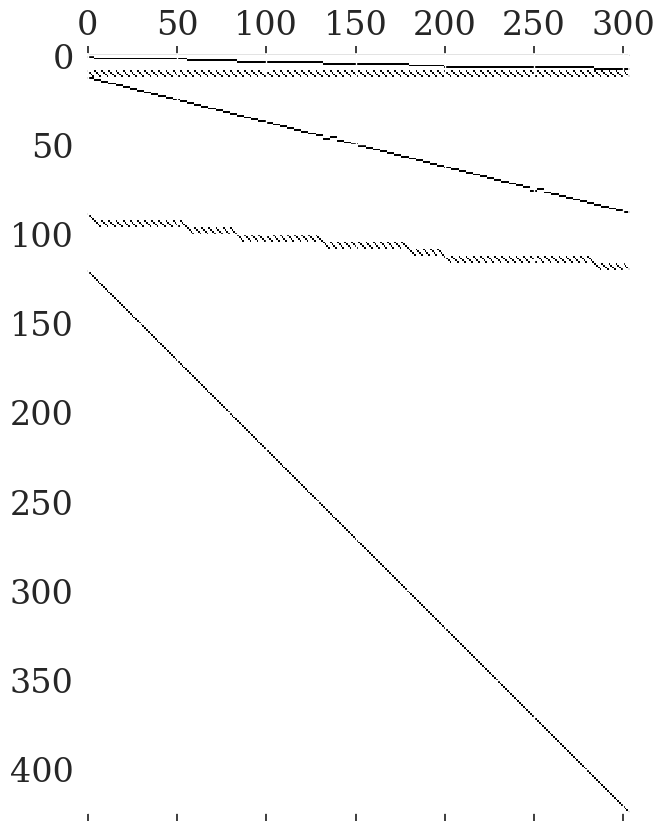

In [82]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
plt.figure(figsize=(7, 15))
hplot.plot_summing_matrix()

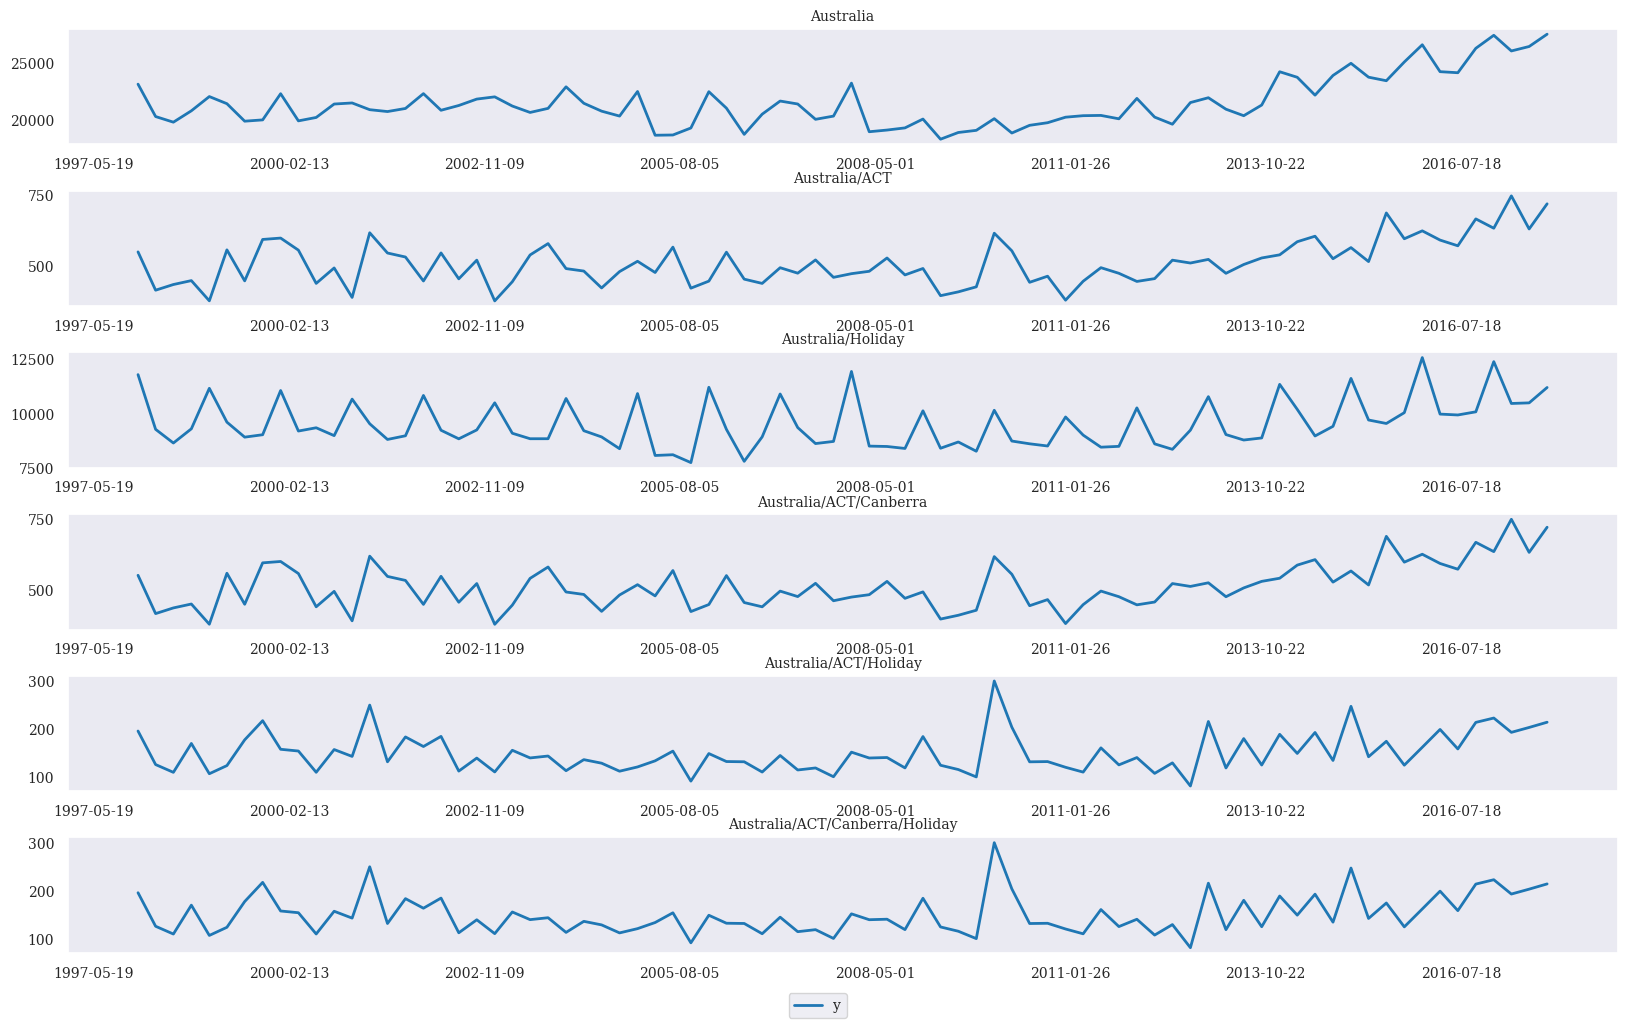

In [83]:
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/ACT/Canberra/Holiday',
    Y_df=Y_df
)

Train-test split

In [85]:
Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

Y_train_df.groupby('unique_id').size()

unique_id
Australia                                                72
Australia/ACT                                            72
Australia/ACT/Business                                   72
Australia/ACT/Canberra                                   72
Australia/ACT/Canberra/Business                          72
                                                         ..
Australia/Western Australia/Experience Perth/Other       72
Australia/Western Australia/Experience Perth/Visiting    72
Australia/Western Australia/Holiday                      72
Australia/Western Australia/Other                        72
Australia/Western Australia/Visiting                     72
Length: 425, dtype: int64

Forecasts: base and reconciled

In [86]:
fcst = StatsForecast(models=[AutoARIMA(season_length=4)], 
                     freq='QS', n_jobs=-1)
Y_hat_df = fcst.forecast(df=Y_train_df, h=8, fitted=True, level=[80, 90])
Y_fitted_df = fcst.forecast_fitted_values()

In [87]:
reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, 
                          S=S_df, tags=tags, level=[80, 90],
                         intervals_method='normality')

In [88]:
Y_rec_df.head()

unique_id         ds     AutoARIMA  AutoARIMA-lo-90  AutoARIMA-lo-80   
0  Australia 2016-01-01  26212.553553     24705.948180     25038.715077  \
1  Australia 2016-04-01  25033.667125     23337.267588     23711.954696   
2  Australia 2016-07-01  24507.027198     22640.028798     23052.396413   
3  Australia 2016-10-01  25598.928613     23575.665243     24022.547410   
4  Australia 2017-01-01  26982.576796     24669.535238     25180.421285   

   AutoARIMA-hi-80  AutoARIMA-hi-90  AutoARIMA/BottomUp   
0     27386.392029     27719.158927        24497.619685  \
1     26355.379554     26730.066662        22658.397974   
2     25961.657983     26374.025599        22308.950158   
3     27175.309816     27622.191983        22858.357381   
4     28784.732308     29295.618354        24282.038999   

   AutoARIMA/BottomUp-lo-90  AutoARIMA/BottomUp-lo-80  ...   
0              23888.915065              24023.360854  ...  \
1              22040.069393              22176.640845  ...   
2              21683.207824              21821.416766  ...   
3              22225.814182              22365.525245  ...   
4              23623.728331              23769.130705  ...   

   AutoARIMA/MinTrace_method-mint_shrink   
0                           25326.626985  \
1                           23875.569394   
2                           23396.672408   
3                           24308.311930   
4                           25525.674382   

   AutoARIMA/MinTrace_method-mint_shrink-lo-90   
0                                 24524.364346  \
1                                 23017.865724   
2                                 22490.952608   
3                                 23357.413015   
4                                 24486.467024   

   AutoARIMA/MinTrace_method-mint_shrink-lo-80   
0                                 24701.561676  \
1                                 23207.308424   
2                                 22691.000725   
3                                 23567.439932   
4                                 24715.998801   

   AutoARIMA/MinTrace_method-mint_shrink-hi-80   
0                                 25951.692293  \
1                                 24543.830364   
2                                 24102.344091   
3                                 25049.183928   
4                                 26335.349964   

   AutoARIMA/MinTrace_method-mint_shrink-hi-90  AutoARIMA/MinTrace_method-ols   
0                                 26128.889623                   26073.097211  \
1                                 24733.273063                   24808.665933   
2                                 24302.392208                   24257.513647   
3                                 25259.210845                   25328.615417   
4                                 26564.881741                   26683.144229   

   AutoARIMA/MinTrace_method-ols-lo-90  AutoARIMA/MinTrace_method-ols-lo-80   
0                         25001.248654                         25237.989957  \
1                         23603.360257                         23869.578497   
2                         22932.403837                         23225.083451   
3                         23893.611234                         24210.563435   
4                         25044.449044                         25406.390878   

   AutoARIMA/MinTrace_method-ols-hi-80  AutoARIMA/MinTrace_method-ols-hi-90  
0                         26908.204464                         27144.945767  
1                         25747.753370                         26013.971609  
2                         25289.943842                         25582.623456  
3                         26446.667399                         26763.619601  
4                         27959.897580                         28321.839414  

[5 rows x 22 columns]

Plot forecasts

In [89]:
plot_df = Y_df.merge(Y_rec_df, on=['unique_id', 'ds'], how="outer")

In [92]:
plot_df

unique_id         ds   
0                                              Australia 1998-01-01  \
1                                              Australia 1998-04-01   
2                                              Australia 1998-07-01   
3                                              Australia 1998-10-01   
4                                              Australia 1999-01-01   
...                                                  ...        ...   
33995  Australia/Western Australia/Experience Perth/V... 2016-10-01   
33996  Australia/Western Australia/Experience Perth/V... 2017-01-01   
33997  Australia/Western Australia/Experience Perth/V... 2017-04-01   
33998  Australia/Western Australia/Experience Perth/V... 2017-07-01   
33999  Australia/Western Australia/Experience Perth/V... 2017-10-01   

                  y   AutoARIMA  AutoARIMA-lo-90  AutoARIMA-lo-80   
0      23182.197269         NaN              NaN              NaN  \
1      20323.380067         NaN              NaN              NaN   
2      19826.640511         NaN              NaN              NaN   
3      20830.129891         NaN              NaN              NaN   
4      22087.353380         NaN              NaN              NaN   
...             ...         ...              ...              ...   
33995    439.699451  378.694895       290.404501       309.905375   
33996    356.867038  381.793277       278.143935       301.037170   
33997    302.296119  412.838927       303.981292       328.024892   
33998    373.442070  389.299280       275.471411       300.612797   
33999    455.316702  401.112428       282.522452       308.715653   

       AutoARIMA-hi-80  AutoARIMA-hi-90  AutoARIMA/BottomUp   
0                  NaN              NaN                 NaN  \
1                  NaN              NaN                 NaN   
2                  NaN              NaN                 NaN   
3                  NaN              NaN                 NaN   
4                  NaN              NaN                 NaN   
...                ...              ...                 ...   
33995       447.484416       466.985289          378.694895   
33996       462.549385       485.442619          381.793277   
33997       497.652963       521.696563          412.838927   
33998       477.985763       503.127149          389.299280   
33999       493.509203       519.702404          401.112428   

       AutoARIMA/BottomUp-lo-90  ...  AutoARIMA/MinTrace_method-mint_shrink   
0                           NaN  ...                                    NaN  \
1                           NaN  ...                                    NaN   
2                           NaN  ...                                    NaN   
3                           NaN  ...                                    NaN   
4                           NaN  ...                                    NaN   
...                         ...  ...                                    ...   
33995                290.404501  ...                             395.349238   
33996                278.143935  ...                             399.400127   
33997                303.981292  ...                             405.645314   
33998                275.471411  ...                             396.009821   
33999                282.522452  ...                             406.350027   

       AutoARIMA/MinTrace_method-mint_shrink-lo-90   
0                                              NaN  \
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   
...                                            ...   
33995                                   317.801255   
33996                                   310.534340   
33997                                   311.942083   
33998                                   297.706938   
33999                                   303.646909   

       Aut

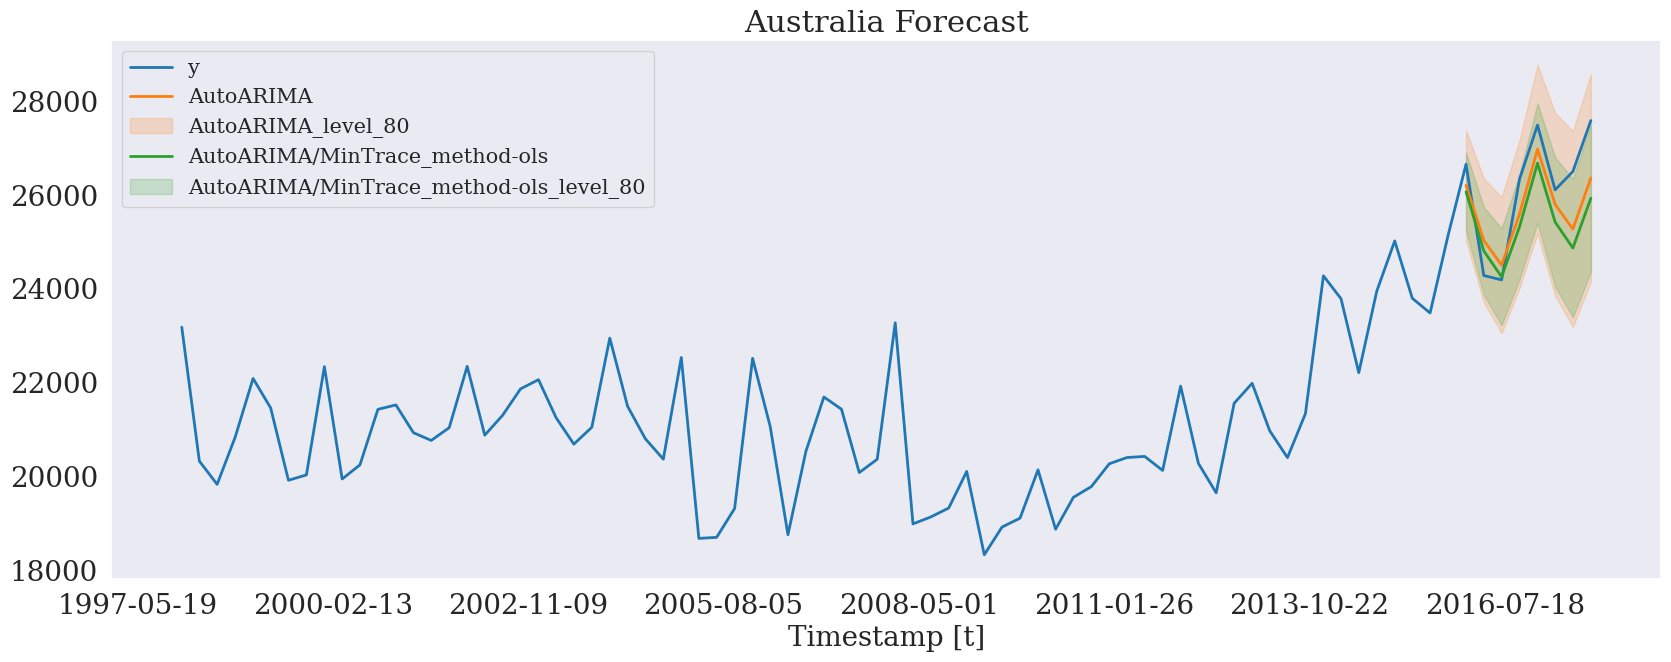

In [90]:
hplot.plot_series(
    series='Australia',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/MinTrace_method-ols'],
    level=[80]
)

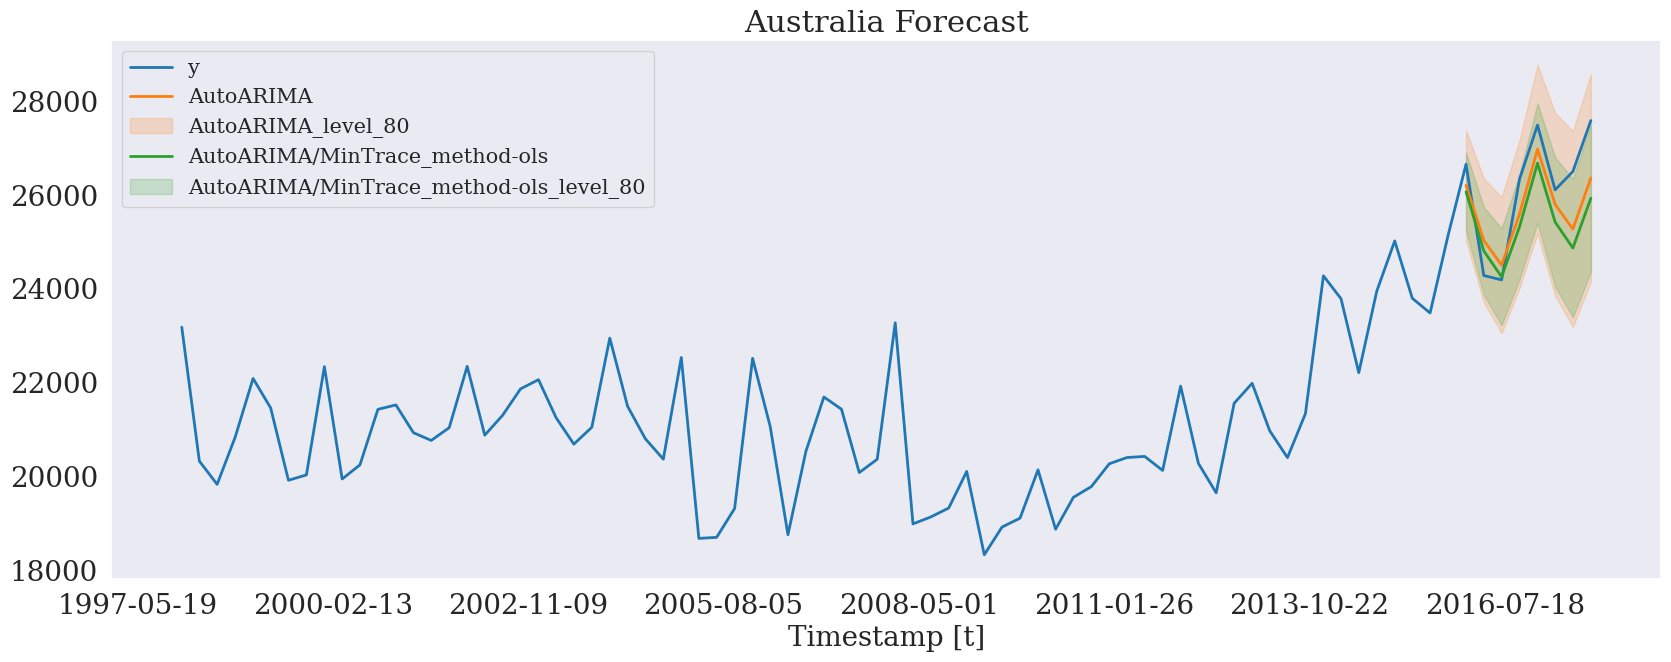

In [91]:
hplot.plot_series(
    series='Australia',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/MinTrace_method-ols'],
    level=[80]
)

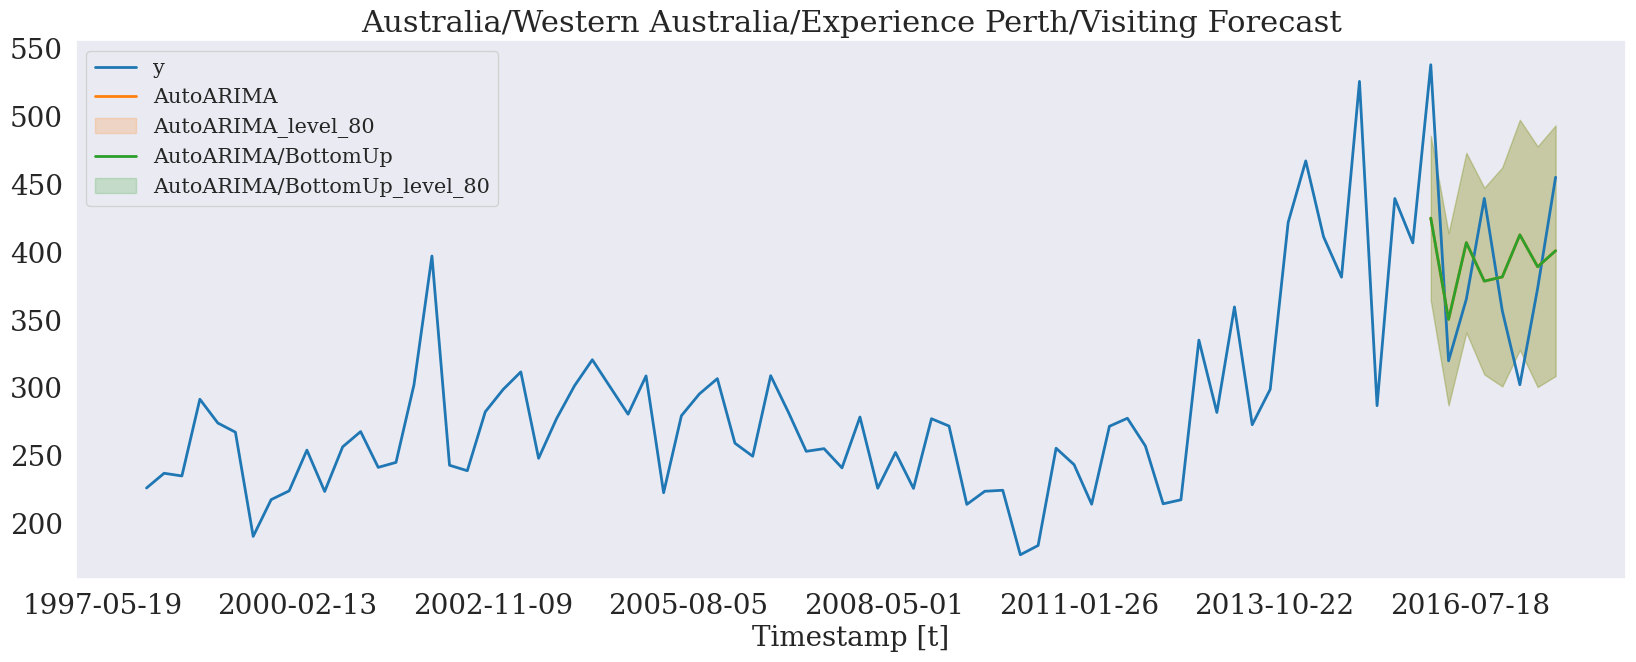

In [93]:
hplot.plot_series(
    series='Australia/Western Australia/Experience Perth/Visiting',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/BottomUp'],
    level=[80]
)

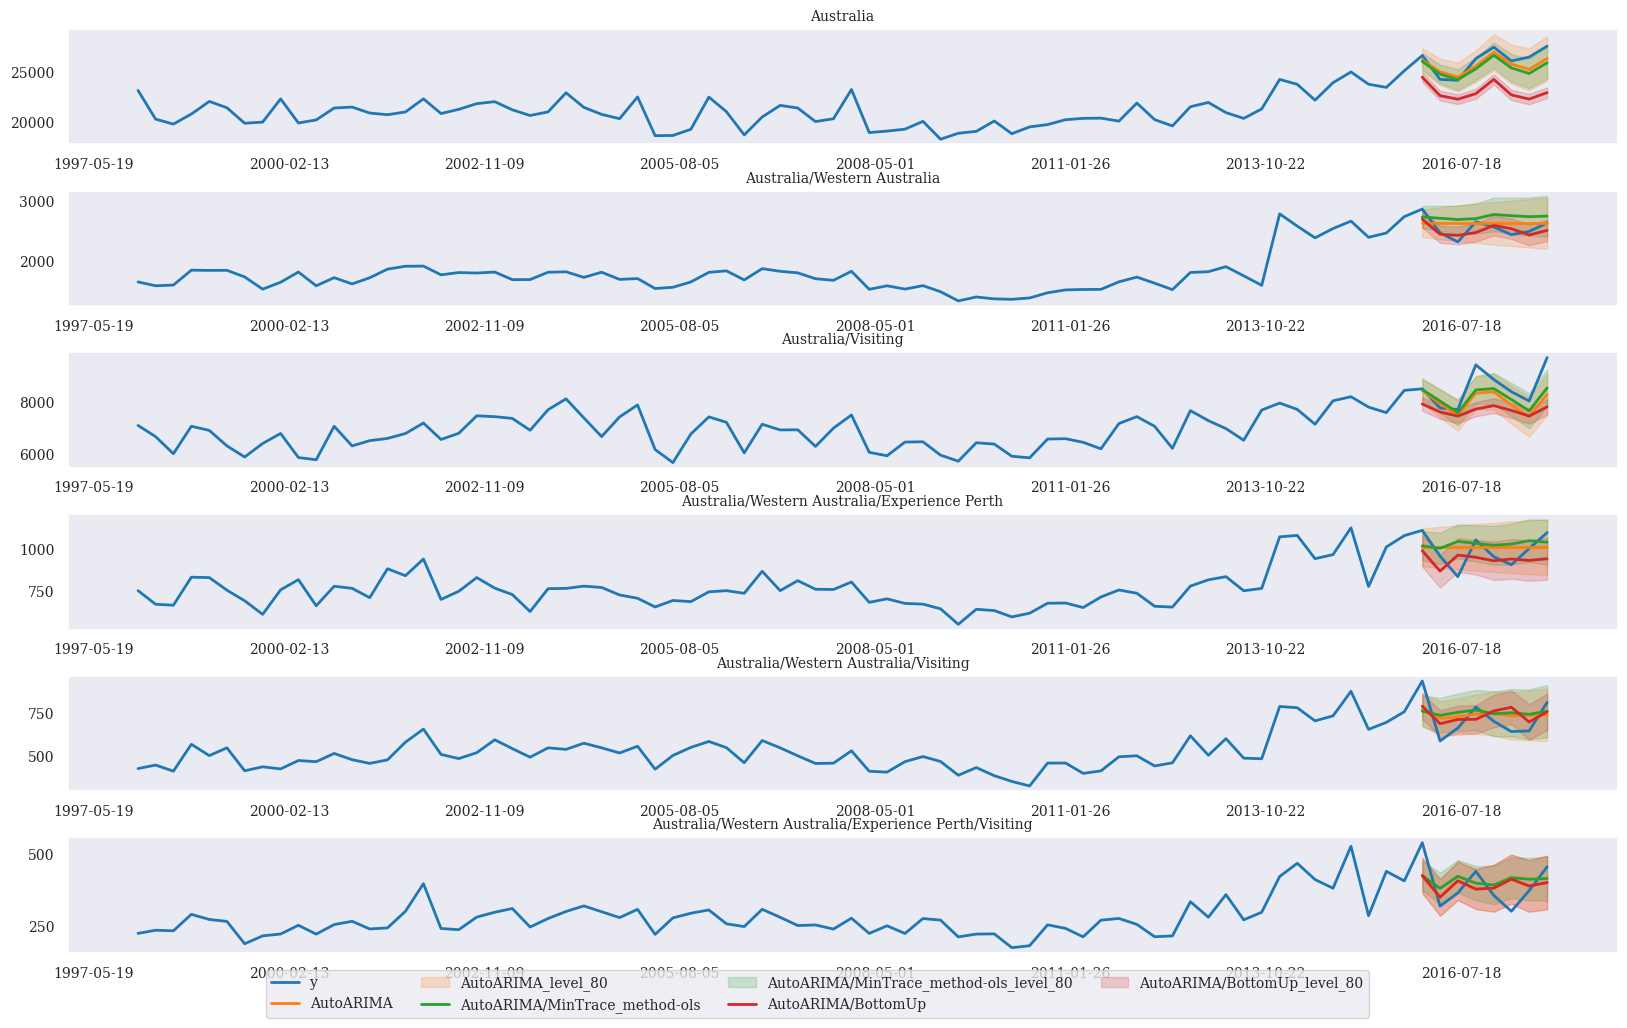

In [94]:
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/Western Australia/Experience Perth/Visiting',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/MinTrace_method-ols', 'AutoARIMA/BottomUp'],
    level=[80]
)

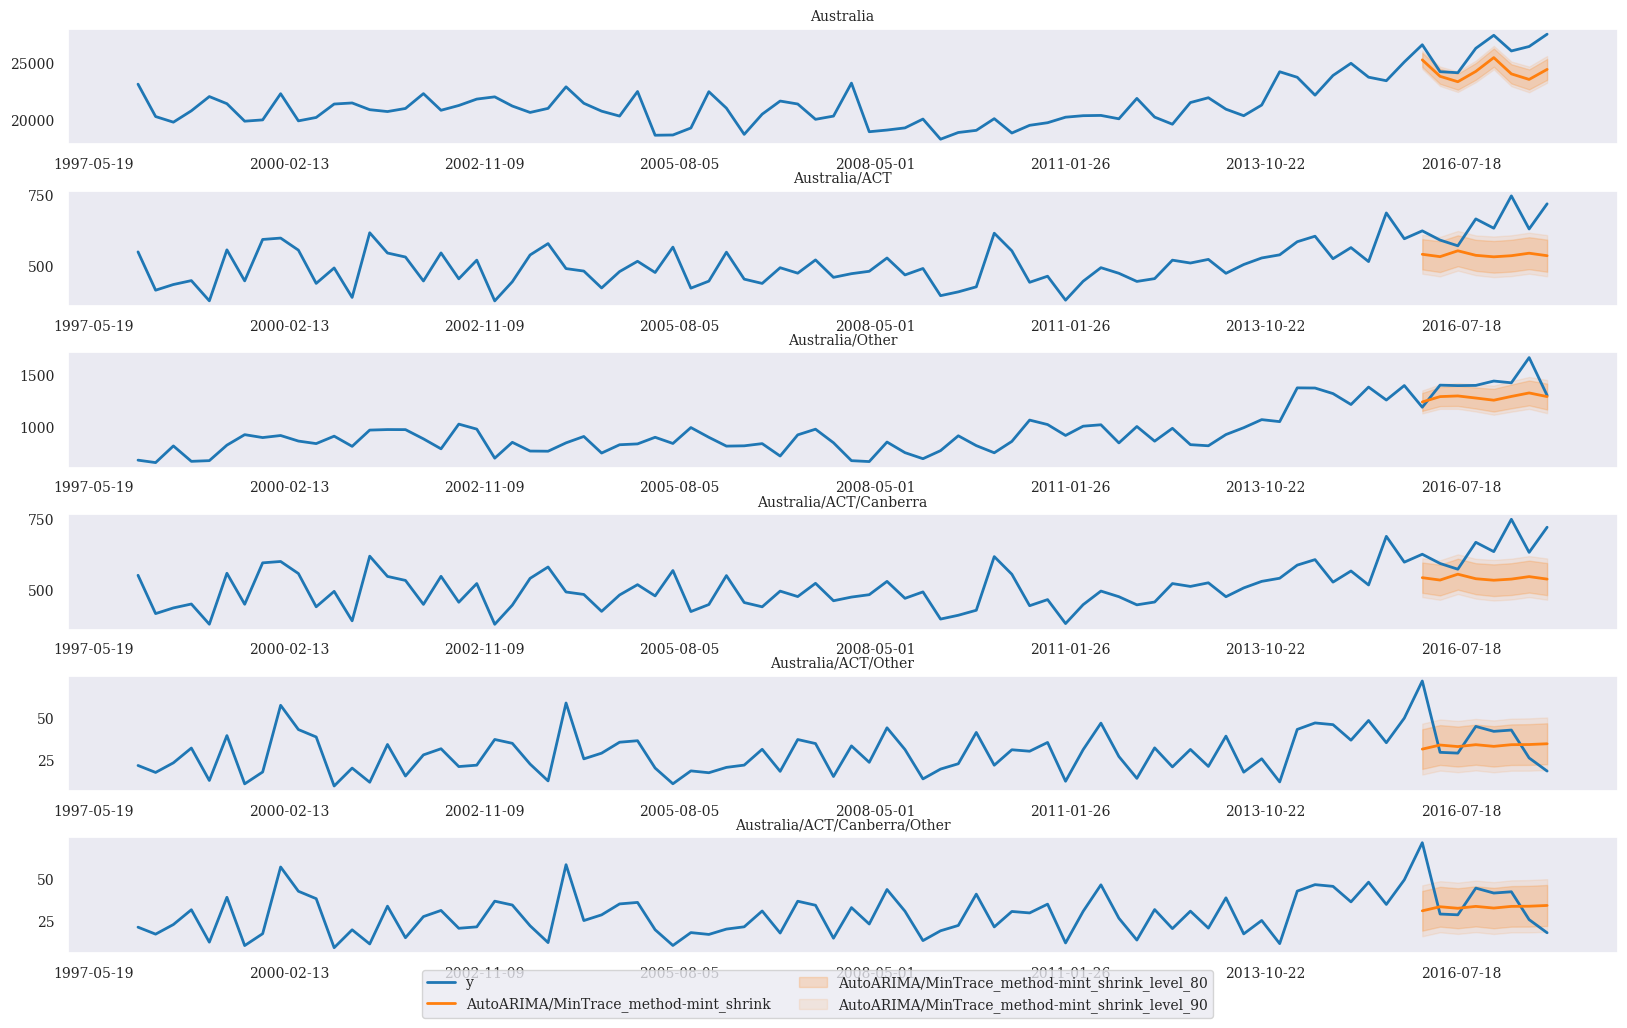

In [95]:
# ACT only has Canberra
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/ACT/Canberra/Other',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA/MinTrace_method-mint_shrink'],
    level=[80, 90]
)

### Bootstrap

In [96]:
reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df, 
                          tags=tags, level=[80, 90], 
                          intervals_method='bootstrap')

In [97]:
Y_rec_df.head()


unique_id         ds     AutoARIMA  AutoARIMA-lo-90  AutoARIMA-lo-80   
0  Australia 2016-01-01  26212.553553     24705.948180     25038.715077  \
1  Australia 2016-04-01  25033.667125     23337.267588     23711.954696   
2  Australia 2016-07-01  24507.027198     22640.028798     23052.396413   
3  Australia 2016-10-01  25598.928613     23575.665243     24022.547410   
4  Australia 2017-01-01  26982.576796     24669.535238     25180.421285   

   AutoARIMA-hi-80  AutoARIMA-hi-90  AutoARIMA/BottomUp   
0     27386.392029     27719.158927        24497.619685  \
1     26355.379554     26730.066662        22658.397974   
2     25961.657983     26374.025599        22308.950158   
3     27175.309816     27622.191983        22858.357381   
4     28784.732308     29295.618354        24282.038999   

   AutoARIMA/BottomUp-lo-90  AutoARIMA/BottomUp-lo-80  ...   
0              22857.994106              23015.796112  ...  \
1              21018.772395              21472.230490  ...   
2              20517.566071              20752.440847  ...   
3              21098.249162              21310.388261  ...   
4              22490.654912              22800.215426  ...   

   AutoARIMA/MinTrace_method-mint_shrink   
0                           25326.626985  \
1                           23875.569394   
2                           23396.672408   
3                           24308.311930   
4                           25525.674382   

   AutoARIMA/MinTrace_method-mint_shrink-lo-90   
0                                 24272.790666  \
1                                 22650.258555   
2                                 21780.587373   
3                                 23063.462381   
4                                 23909.589347   

   AutoARIMA/MinTrace_method-mint_shrink-lo-80   
0                                 24457.497266  \
1                                 23006.439675   
2                                 22522.610850   
3                                 23389.863813   
4                                 24607.226265   

   AutoARIMA/MinTrace_method-mint_shrink-hi-80   
0                                 26292.251466  \
1                                 24769.274079   
2                                 24452.924220   
3                                 25364.563742   
4                                 26671.100649   

   AutoARIMA/MinTrace_method-mint_shrink-hi-90  AutoARIMA/MinTrace_method-ols   
0                                 26472.053251                   26073.097211  \
1                                 24936.279929                   24808.665933   
2                                 24630.177173                   24257.513647   
3                                 25648.525958                   25328.615417   
4                                 26928.214000                   26683.144229   

   AutoARIMA/MinTrace_method-ols-lo-90  AutoARIMA/MinTrace_method-ols-lo-80   
0                         24869.165661                         25215.560443  \
1                         23504.943702                         23881.316126   
2                         22809.453598                         23330.163840   
3                         24017.676295                         24290.275235   
4                         25235.084180                         25768.126686   

   AutoARIMA/MinTrace_method-ols-hi-80  AutoARIMA/MinTrace_method-ols-hi-90  
0                         27455.294797                         27561.127434  
1                         26109.533679                         26295.340562  
2                         25639.711233                         25775.563763  
3                         26710.813004                         26846.665534  
4                         28065.341816                         28201.194346  

[5 rows x 22 columns]

Plot predictions

In [98]:
plot_df = Y_df.merge(Y_rec_df, on=['unique_id', 'ds'], how="outer")

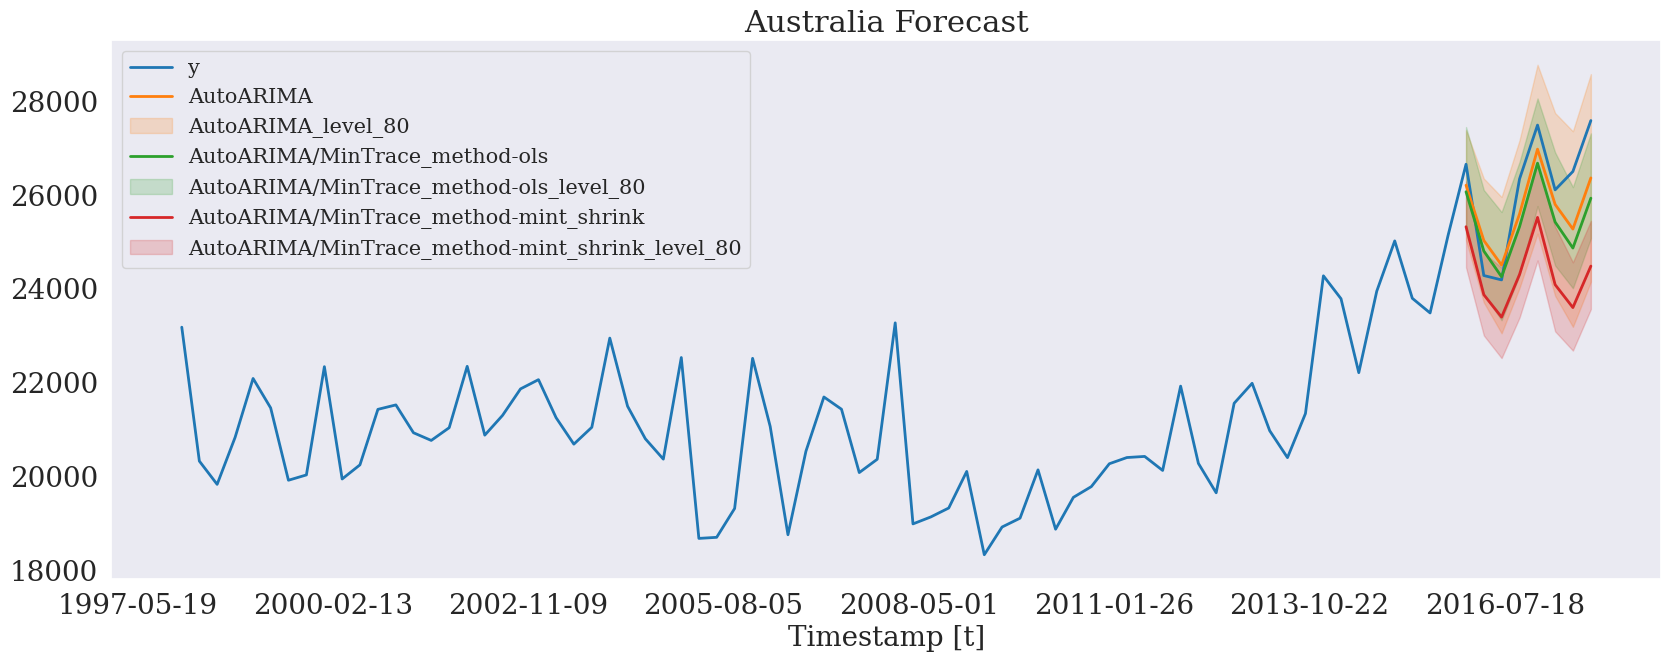

In [100]:
hplot.plot_series(
    series='Australia',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/MinTrace_method-ols', 'AutoARIMA/MinTrace_method-mint_shrink'],
    level=[80]
)

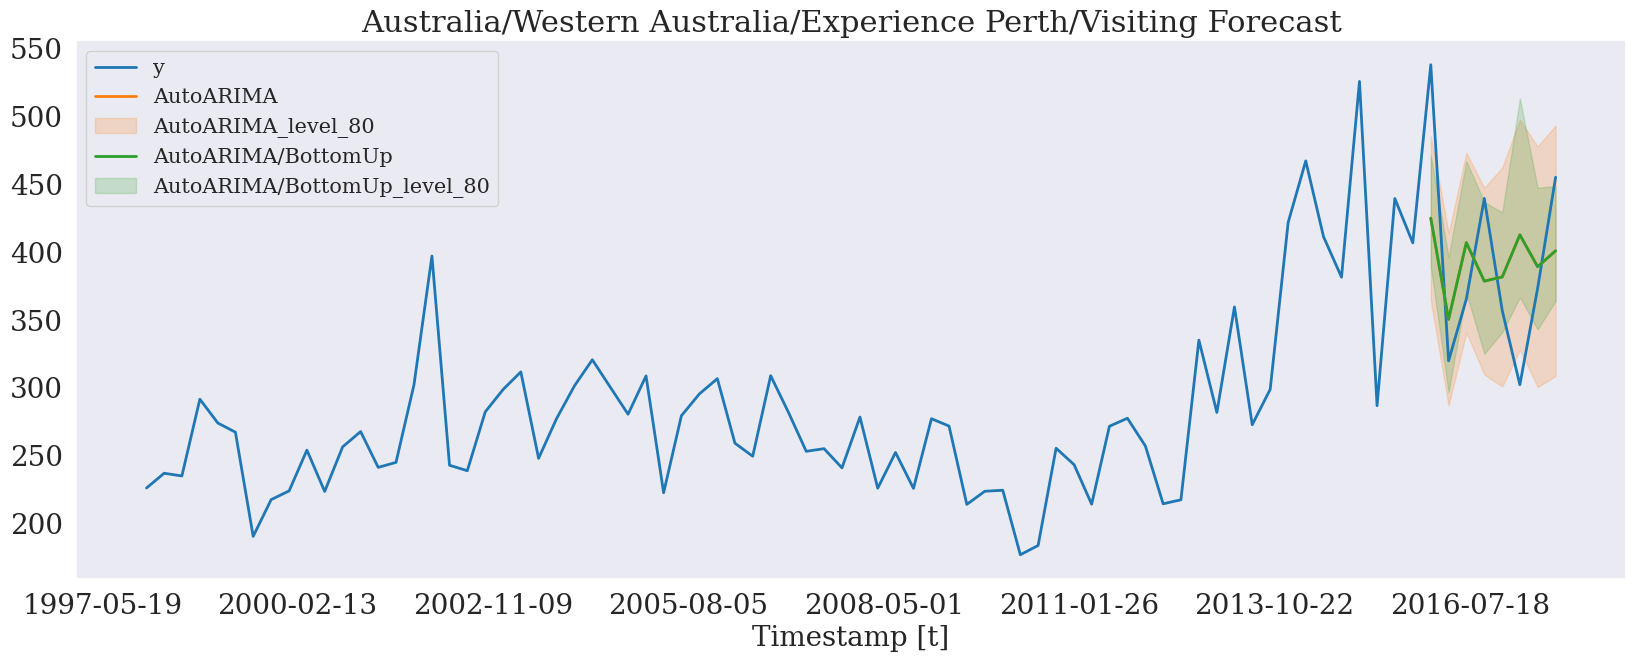

In [101]:
hplot.plot_series(
    series='Australia/Western Australia/Experience Perth/Visiting',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/BottomUp'],
    level=[80]
)

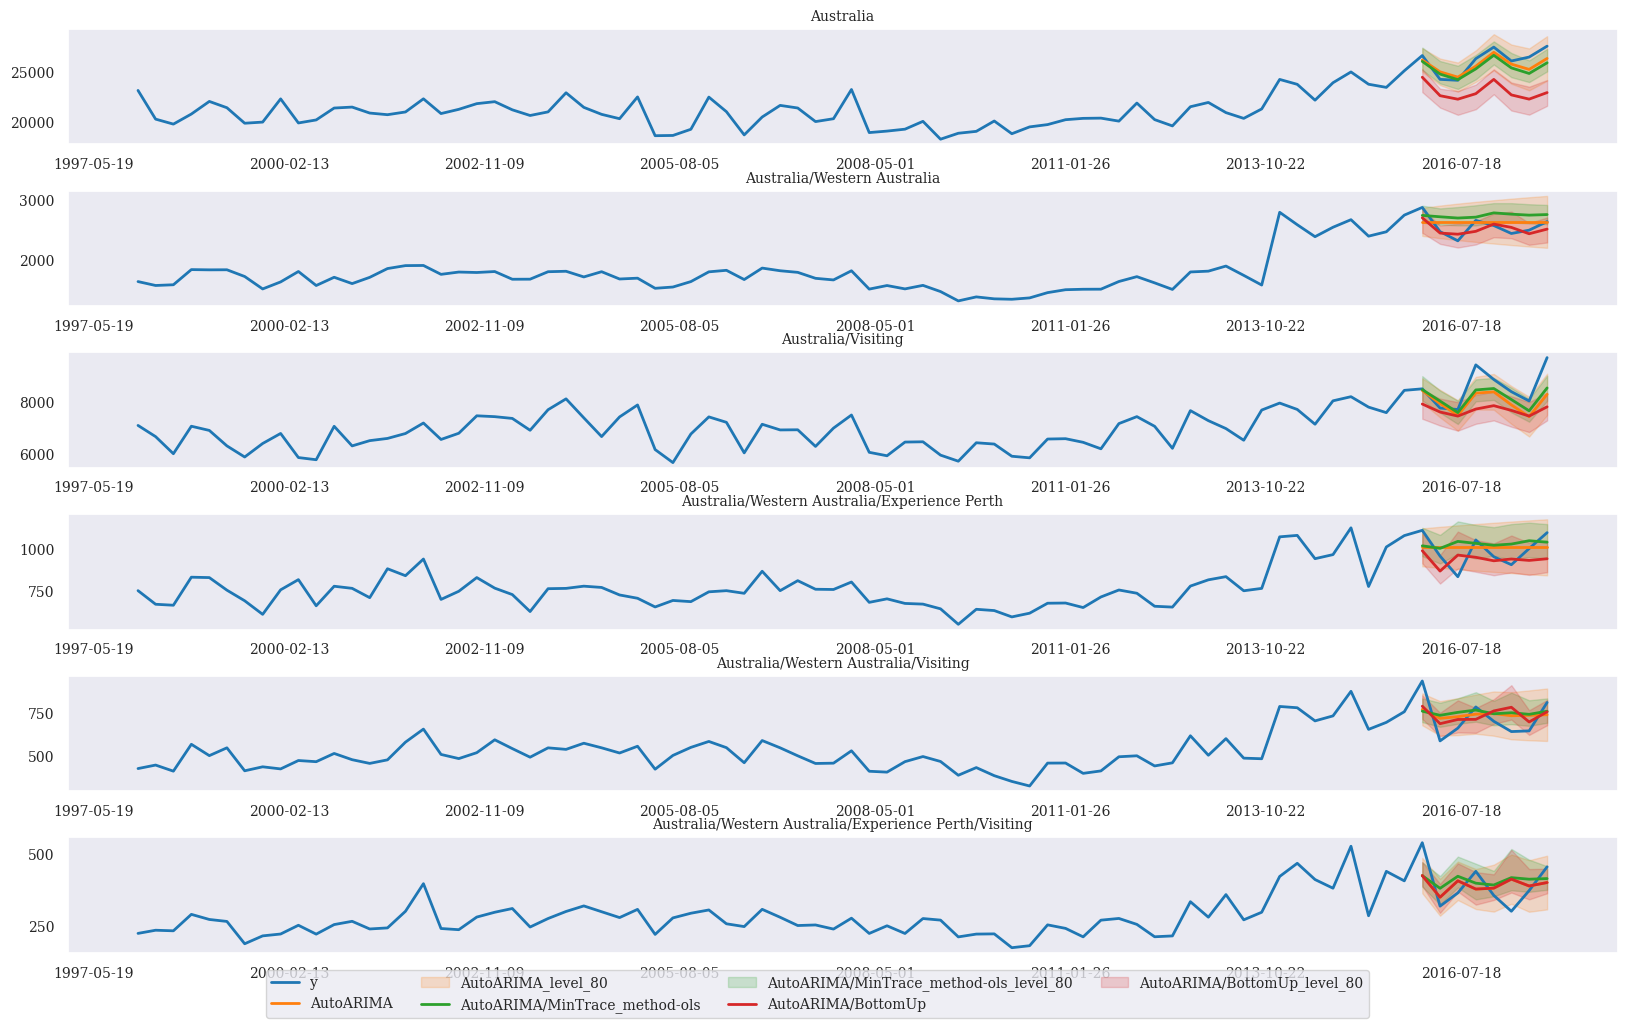

In [102]:
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/Western Australia/Experience Perth/Visiting',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/MinTrace_method-ols', 'AutoARIMA/BottomUp'],
    level=[80]
)

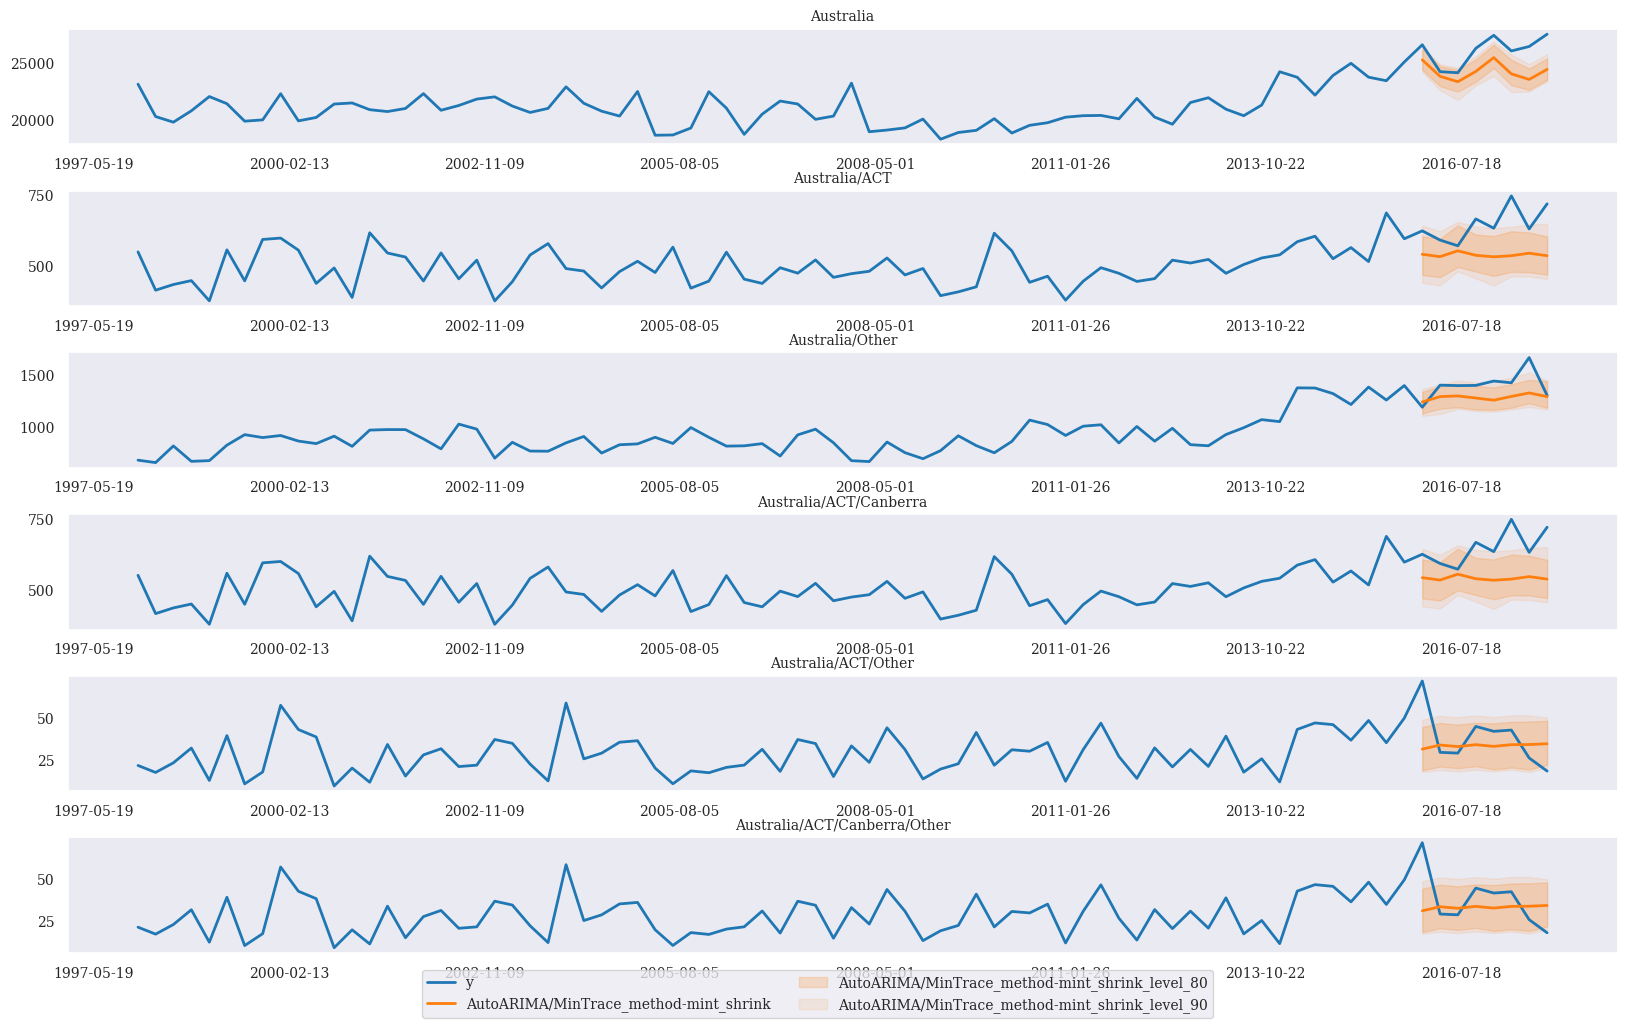

In [103]:
# ACT only has Canberra
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/ACT/Canberra/Other',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA/MinTrace_method-mint_shrink'],
    level=[80, 90]
)

### PERMBU

In [109]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.PeriodIndex(Y_df["ds"], freq='Q').to_timestamp()

spec = [
    ['Country'],
    ['Country', 'State'], 
    ['Country', 'State', 'Region']
]

Y_df.head()

Country    Region            State   Purpose         ds           y
0  Australia  Adelaide  South Australia  Business 1998-01-01  135.077690
1  Australia  Adelaide  South Australia  Business 1998-04-01  109.987316
2  Australia  Adelaide  South Australia  Business 1998-07-01  166.034687
3  Australia  Adelaide  South Australia  Business 1998-10-01  127.160464
4  Australia  Adelaide  South Australia  Business 1999-01-01  137.448533

In [110]:
Y_df, S_df, tags = aggregate(df=Y_df, spec=spec)
hplot = HierarchicalPlot(S=S_df, tags=tags)

Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

fcst = StatsForecast(models=[AutoARIMA(season_length=4)], 
                     freq='QS', n_jobs=-1)
Y_hat_df = fcst.forecast(df=Y_train_df, h=8, fitted=True, level=[80, 90])
Y_fitted_df = fcst.forecast_fitted_values()

reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df,
                          S=S_df, tags=tags,
                          level=[80, 90], intervals_method='permbu')

Plot forecasts

In [111]:
plot_df = Y_df.merge(Y_rec_df, on=['unique_id', 'ds'], how="outer")

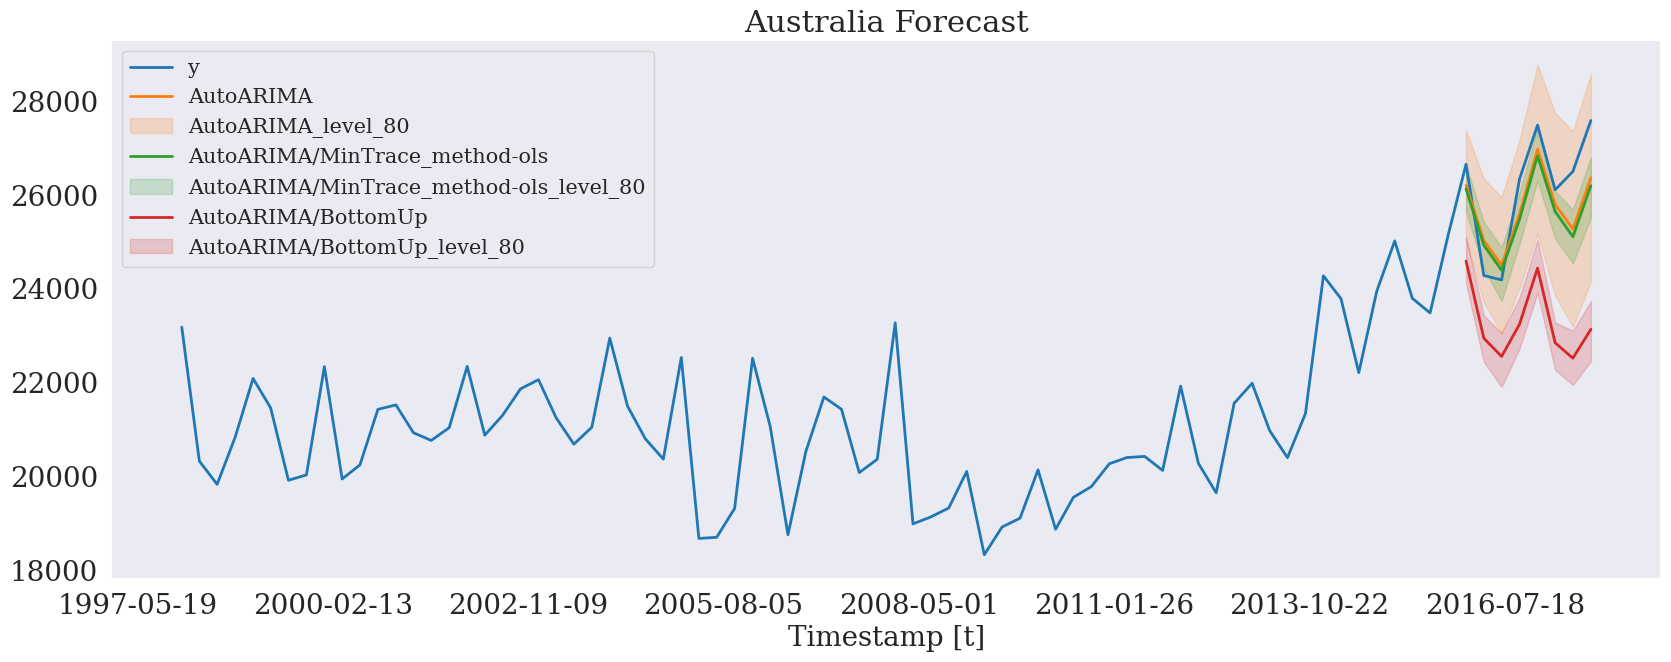

In [112]:
hplot.plot_series(
    series='Australia',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 
            'AutoARIMA/MinTrace_method-ols',
            'AutoARIMA/BottomUp'
           ],
    level=[80]
)

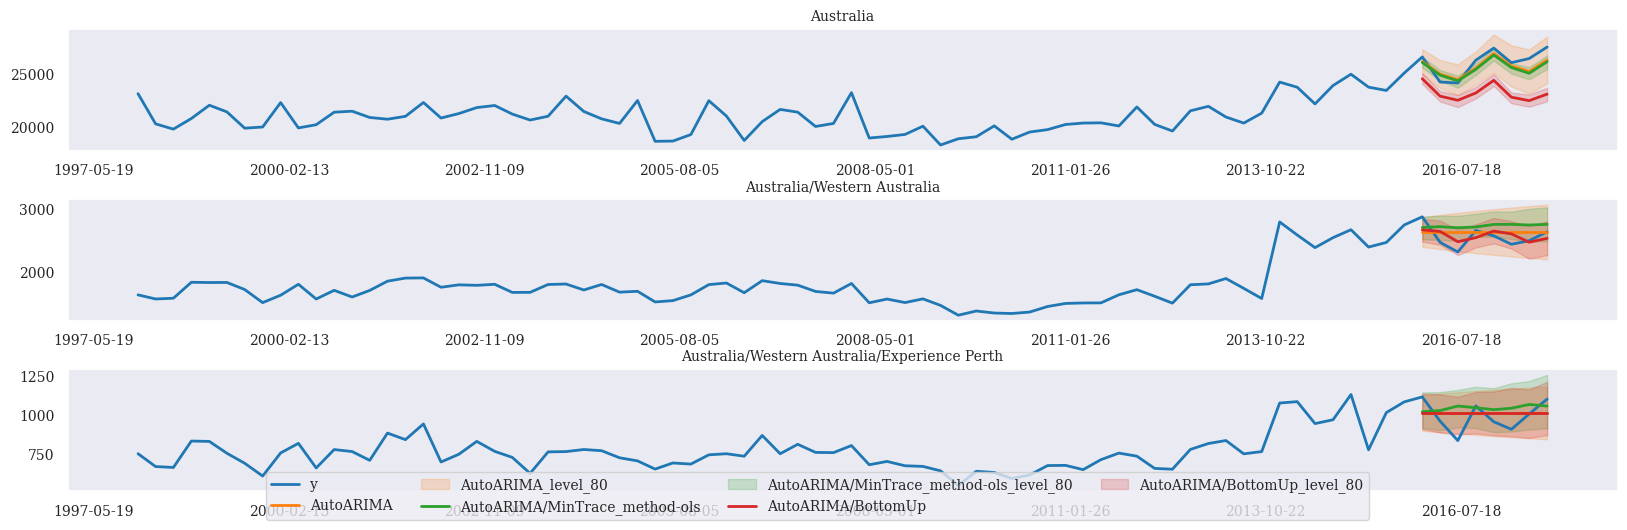

In [113]:
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/Western Australia/Experience Perth',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/MinTrace_method-ols', 'AutoARIMA/BottomUp'],
    level=[80]
)

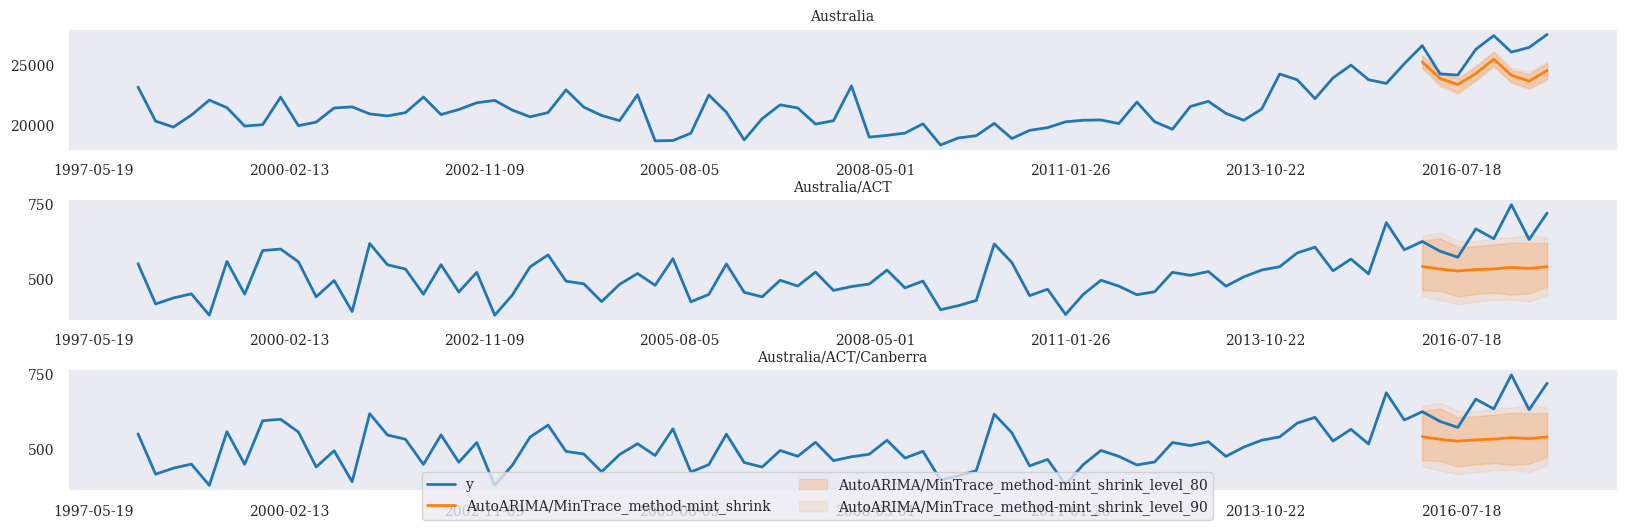

In [114]:
# ACT only has Canberra
hplot.plot_hierarchically_linked_series(
    bottom_series='Australia/ACT/Canberra',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA/MinTrace_method-mint_shrink'],
    level=[80, 90]
)

### Probabilistic Forecast Evaluation

Prepare data

In [117]:
dataset = 'TourismSmall' # 'TourismLarge'
verbose = True
intervals_method = 'bootstrap'
LEVEL = np.arange(0, 100, 2)

In [118]:
with CodeTimer('Read and Parse data   ', verbose):
    print(f'{dataset}')
    if not os.path.exists('./data'):
        os.makedirs('./data')
    
    dataset_info = HierarchicalInfo[dataset]
    Y_df, S_df, tags = HierarchicalData.load(directory=f'./data/{dataset}', group=dataset)
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])

    # Train/Test Splits
    horizon = dataset_info.horizon
    seasonality = dataset_info.seasonality
    Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(horizon)
    Y_train_df = Y_df.drop(Y_test_df.index)
    S_df = S_df.reset_index(names="unique_id")

TourismSmall


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.30M/1.30M [00:04<00:00, 285kiB/s]
INFO:datasetsforecast.utils:Successfully downloaded datasets.zip, 1297274, bytes.
INFO:datasetsforecast.utils:Decompressing zip file...
INFO:datasetsforecast.utils:Successfully decompressed data/TourismSmall/hierarchical/datasets.zip
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335k/335k [00:04<00:00, 82.0kiB/s]
INFO:datasetsforecast.utils:Successfully downloaded OldTraffic.zip, 335471, bytes.
INFO:datasetsforecast.utils:Decompressing zip file...
INFO:datasetsforecast.utils:Successfully decompressed data/TourismSmall/hierarchical/OldTraffic.zip
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 968k/968k [00:02<00:00, 372kiB/s]
INFO:datasetsforecast.utils:Successfully downloaded OldTourismLarge.zi

Code block 'Read and Parse data   ' took:	16.44089 seconds


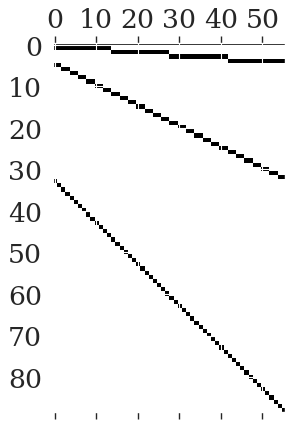

In [119]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

Base predictions

In [120]:
with CodeTimer('Fit/Predict Model     ', verbose):
    # Read to avoid unnecesary AutoARIMA computation
    yhat_file = f'./data/{dataset}/Y_hat.csv'
    yfitted_file = f'./data/{dataset}/Y_fitted.csv'

    if os.path.exists(yhat_file):
        Y_hat_df = pd.read_csv(yhat_file, parse_dates=['ds'])
        Y_fitted_df = pd.read_csv(yfitted_file, parse_dates=['ds'])

    else:
        fcst = StatsForecast(
            models=[AutoARIMA(season_length=seasonality)],
            fallback_model=[Naive()],
            freq=dataset_info.freq, 
            n_jobs=-1
        )
        Y_hat_df = fcst.forecast(df=Y_train_df, h=horizon, fitted=True, level=LEVEL)
        Y_fitted_df = fcst.forecast_fitted_values()
        Y_hat_df.to_csv(yhat_file, index=False)
        Y_fitted_df.to_csv(yfitted_file, index=False)

Code block 'Fit/Predict Model     ' took:	3.80634 seconds


/home/eduard/mambaforge/envs/mix/lib/python3.9/site-packages/statsforecast/core.py:887: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fcsts_df[cols] = fcsts
/home/eduard/mambaforge/envs/mix/lib/python3.9/site-packages/statsforecast/core.py:887: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fcsts_df[cols] = fcsts
/home/eduard/mambaforge/envs/mix/lib/python3.9/site-packages/statsforecast/core.py:887: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

Reconcile rpedictions

In [121]:
with CodeTimer('Reconcile Predictions ', verbose):
    if is_strictly_hierarchical(S=S_df.drop(columns="unique_id").values.astype(np.float32), tags={key: S_df["unique_id"].isin(val).values.nonzero()[0] for key, val in tags.items()}):
        reconcilers = [
            BottomUp(),
            TopDown(method='average_proportions'),
            TopDown(method='proportion_averages'),
            MinTrace(method='ols'),
            MinTrace(method='wls_var'),
            MinTrace(method='mint_shrink'),
            ERM(method='closed'),
        ]
    else:
        reconcilers = [
            BottomUp(),
            MinTrace(method='ols'),
            MinTrace(method='wls_var'),
            MinTrace(method='mint_shrink'),
            ERM(method='closed'),
        ]
    
    hrec = HierarchicalReconciliation(reconcilers=reconcilers)
    Y_rec_df = hrec.bootstrap_reconcile(Y_hat_df=Y_hat_df,
                                        Y_df=Y_fitted_df,
                                        S_df=S_df, tags=tags,
                                        level=LEVEL,
                                        intervals_method=intervals_method,
                                        num_samples=10, 
                                        num_seeds=10)
    
    Y_rec_df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'], how="left")

Code block 'Reconcile Predictions ' took:	6.41539 seconds


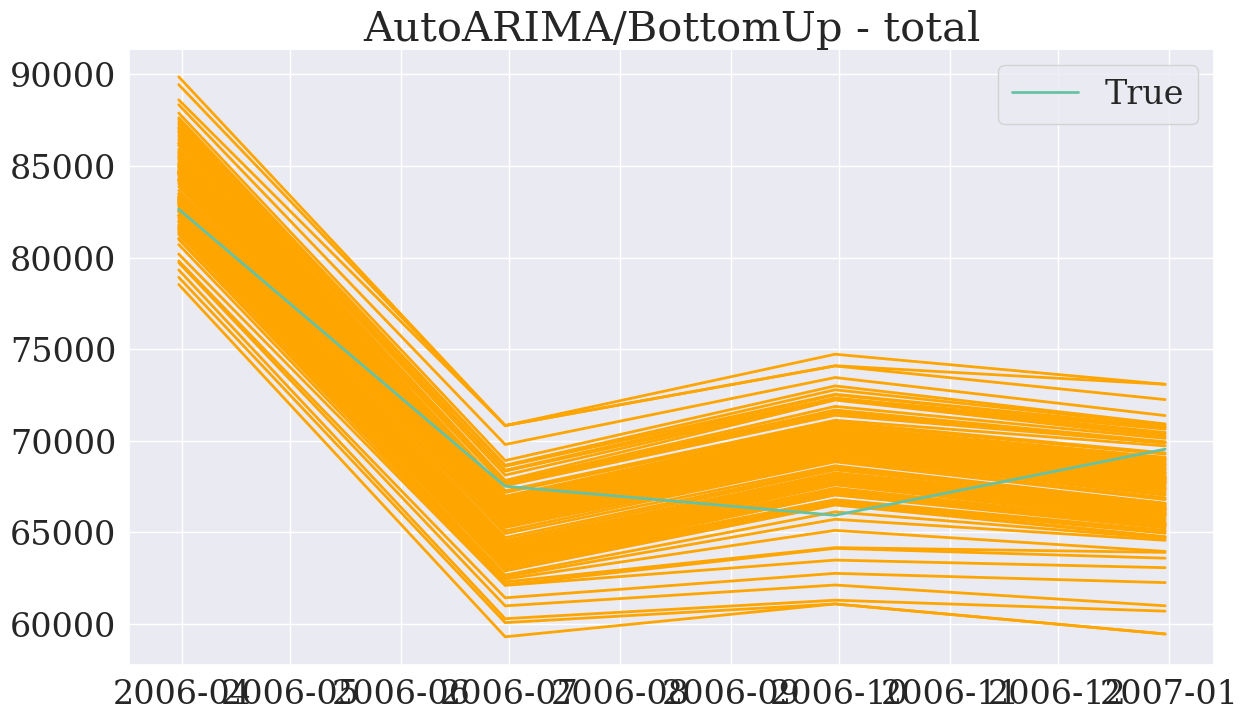

In [122]:
unique_id = "total"
plot_df = Y_rec_df.query("unique_id == @unique_id").groupby(["unique_id", "ds"], as_index=False).mean()
for col in hrec.level_names['AutoARIMA/BottomUp']:
    plt.plot(plot_df["ds"], plot_df[col], color="orange")
plt.plot(plot_df["ds"], plot_df["y"], label="True")
plt.title(f"AutoARIMA/BottomUp - {unique_id}")
plt.legend()

Evaluate

In [125]:
with CodeTimer('Evaluate Models CRPS and MSSE ', verbose):
    metrics_seeds = []
    for seed in Y_rec_df.seed.unique():
        df_seed = Y_rec_df.query("seed == @seed")
        metrics_seed = evaluate(df = df_seed,
                            tags = tags,
                            metrics = [scaled_crps, 
                                       partial(msse, seasonality=4)],
                            models= hrec.level_names.keys(),
                            level = LEVEL,
                            train_df = Y_train_df,
                            )
        metrics_seed['seed'] = seed
        metrics_seeds.append(metrics_seed)
    metrics_seeds = pd.concat(metrics_seeds)

    metrics_mean = metrics_seeds.groupby(["level", "metric"], as_index=False).mean()
    metrics_std = metrics_seeds.groupby(["level", "metric"], as_index=False).std()

    results = metrics_mean[hrec.level_names.keys()].round(3).astype(str) + "±" + metrics_std[hrec.level_names.keys()].round(4).astype(str)
    results.insert(0, "metric", metrics_mean["metric"])
    results.insert(0, "level", metrics_mean["level"])

results.sort_values(by=["metric", "level"])

Code block 'Evaluate Models CRPS and MSSE ' took:	3.12889 seconds


level       metric AutoARIMA/BottomUp   
0                            Country         msse          0.441±0.0  \
2                    Country/Purpose         msse          1.011±0.0   
4              Country/Purpose/State         msse           0.63±0.0   
6  Country/Purpose/State/CityNonCity         msse          0.738±0.0   
8                            Overall         msse          0.713±0.0   
1                            Country  scaled_crps        0.02±0.0011   
3                    Country/Purpose  scaled_crps       0.067±0.0014   
5              Country/Purpose/State  scaled_crps       0.138±0.0013   
7  Country/Purpose/State/CityNonCity  scaled_crps        0.19±0.0013   
9                            Overall  scaled_crps       0.167±0.0012   

  AutoARIMA/TopDown_method-average_proportions   
0                                    0.982±0.0  \
2                                    1.939±0.0   
4                                    1.533±0.0   
6                                    1.187±0.0   
8                                    1.327±0.0   
1                                 0.033±0.0015   
3                                   0.11±0.001   
5                                  0.242±0.001   
7                                   0.29±0.001   
9                                  0.264±0.001   

  AutoARIMA/TopDown_method-proportion_averages AutoARIMA/MinTrace_method-ols   
0                                    0.982±0.0                     0.937±0.0  \
2                                    1.835±0.0                     1.805±0.0   
4                                    1.508±0.0                     0.933±0.0   
6                                    1.175±0.0                     0.927±0.0   
8                                    1.308±0.0                     0.969±0.0   
1                                 0.033±0.0015                  0.033±0.0014   
3                                  0.107±0.001                  0.118±0.0018   
5                                  0.238±0.001                  0.217±0.0022   
7                                  0.286±0.001                   0.26±0.0015   
9                                   0.26±0.001                  0.238±0.0016   

  AutoARIMA/MinTrace_method-wls_var AutoARIMA/MinTrace_method-mint_shrink   
0                         0.735±0.0                             0.796±0.0  \
2                         1.136±0.0                             1.155±0.0   
4                         0.683±0.0                             0.685±0.0   
6                         0.774±0.0                             0.777±0.0   
8                         0.761±0.0                             0.765±0.0   
1                      0.026±0.0009                          0.027±0.0009   
3                      0.076±0.0016                          0.074±0.0015   
5                      0.145±0.0012                          0.142±0.0011   
7                      0.193±0.0013                          0.191±0.0012   
9                      0.171±0.0012                           0.169±0.001   

  AutoARIMA/ERM_method-closed_lambda_reg-0.01  
0                                    4.32±0.0  
2                                   2.997±0.0  
4                                   1.205±0.0  
6                                   1.193±0.0  
8                                   1.313±0.0  
1                                0.077±0.0015  
3                                0.109±0.0013  
5                                0.213±0.0012  
7                                0.267±0.0013  
9                                 0.24±0.0012

## Temporal reconcilation

### Temporal aggregation (Tourism)

In [4]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.PeriodIndex(Y_df["ds"], freq='Q').to_timestamp()
Y_df.head()

Country    Region            State   Purpose         ds           y
0  Australia  Adelaide  South Australia  Business 1998-01-01  135.077690
1  Australia  Adelaide  South Australia  Business 1998-04-01  109.987316
2  Australia  Adelaide  South Australia  Business 1998-07-01  166.034687
3  Australia  Adelaide  South Australia  Business 1998-10-01  127.160464
4  Australia  Adelaide  South Australia  Business 1999-01-01  137.448533

In [5]:
Y_df["unique_id"] = Y_df["Country"] + "/" + Y_df["State"] + "/" + Y_df["Region"] + "/" + Y_df["Purpose"]

In [6]:
horizon = 8

Y_test_df = Y_df.groupby("unique_id", as_index=False).tail(horizon)
Y_train_df = Y_df.drop(Y_test_df.index)

spec_temporal = {"year": 4, "semiannual": 2, "quarter": 1}

In [9]:
Y_train_df, S_train_df, tags_train = aggregate_temporal(df=Y_train_df, spec=spec_temporal)
Y_test_df, S_test_df, tags_test = aggregate_temporal(df=Y_test_df,  spec=spec_temporal)

In [12]:
print(Y_train_df.shape)
Y_train_df.sample(10)

(38304, 4)


temporal_id                                          unique_id   
12226  semiannual-23   Australia/Tasmania/Hobart and the South/Visiting  \
25567      quarter-8  Australia/Queensland/Tropical North Queensland...   
24549     quarter-70             Australia/Queensland/Northern/Business   
6792   semiannual-25        Australia/New South Wales/Riverina/Business   
13266  semiannual-19  Australia/Victoria/Geelong and the Bellarine/B...   
37358     quarter-63  Australia/Western Australia/Australia's Golden...   
14180  semiannual-33                 Australia/Victoria/Macedon/Holiday   
28998     quarter-55          Australia/South Australia/Riverland/Other   
31246     quarter-71          Australia/Victoria/Bendigo Loddon/Holiday   
11600   semiannual-9        Australia/South Australia/Murraylands/Other   

              ds           y  
12226 2009-04-01  146.521818  
25567 1999-10-01  101.503150  
24549 2015-04-01  115.445769  
6792  2010-04-01   64.431648  
13266 2007-04-01   25.282067  
37358 2013-07-01    0.743826  
14180 2014-04-01   46.250626  
28998 2011-07-01    1.053634  
31246 2015-07-01   65.205056  
11600 2002-04-01    4.641282

In [10]:
tags_train

{'year': array(['year-1', 'year-2', 'year-3', 'year-4', 'year-5', 'year-6',
        'year-7', 'year-8', 'year-9', 'year-10', 'year-11', 'year-12',
        'year-13', 'year-14', 'year-15', 'year-16', 'year-17', 'year-18'],
       dtype=object),
 'semiannual': array(['semiannual-1', 'semiannual-2', 'semiannual-3', 'semiannual-4',
        'semiannual-5', 'semiannual-6', 'semiannual-7', 'semiannual-8',
        'semiannual-9', 'semiannual-10', 'semiannual-11', 'semiannual-12',
        'semiannual-13', 'semiannual-14', 'semiannual-15', 'semiannual-16',
        'semiannual-17', 'semiannual-18', 'semiannual-19', 'semiannual-20',
        'semiannual-21', 'semiannual-22', 'semiannual-23', 'semiannual-24',
        'semiannual-25', 'semiannual-26', 'semiannual-27', 'semiannual-28',
        'semiannual-29', 'semiannual-30', 'semiannual-31', 'semiannual-32',
        'semiannual-33', 'semiannual-34', 'semiannual-35', 'semiannual-36'],
       dtype=object),
 'quarter': array(['quarter-1', 'quarter-2',

In [15]:
Y_test_df_new = make_future_dataframe(Y_train_df, freq="QS", h=horizon)
Y_test_df_new, S_test_df_new, tags_test_new = aggregate_temporal(df=Y_test_df_new,  spec=spec_temporal)


In [16]:
Y_test_df

temporal_id                                          unique_id   
0         year-1                    Australia/ACT/Canberra/Business  \
1         year-2                    Australia/ACT/Canberra/Business   
2         year-1                     Australia/ACT/Canberra/Holiday   
3         year-2                     Australia/ACT/Canberra/Holiday   
4         year-1                       Australia/ACT/Canberra/Other   
...          ...                                                ...   
4251   quarter-4  Australia/Western Australia/Experience Perth/V...   
4252   quarter-5  Australia/Western Australia/Experience Perth/V...   
4253   quarter-6  Australia/Western Australia/Experience Perth/V...   
4254   quarter-7  Australia/Western Australia/Experience Perth/V...   
4255   quarter-8  Australia/Western Australia/Experience Perth/V...   

             ds           y  
0    2016-10-01  754.139245  
1    2017-10-01  809.950839  
2    2016-10-01  735.365896  
3    2017-10-01  834.717900  
4    2016-10-01  175.239916  
...         ...         ...  
4251 2016-10-01  439.699451  
4252 2017-01-01  356.867038  
4253 2017-04-01  302.296119  
4254 2017-07-01  373.442070  
4255 2017-10-01  455.316702  

[4256 rows x 4 columns]

In [17]:
Y_test_df_new

temporal_id                                          unique_id         ds
0         year-1                    Australia/ACT/Canberra/Business 2016-10-01
1         year-2                    Australia/ACT/Canberra/Business 2017-10-01
2         year-1                     Australia/ACT/Canberra/Holiday 2016-10-01
3         year-2                     Australia/ACT/Canberra/Holiday 2017-10-01
4         year-1                       Australia/ACT/Canberra/Other 2016-10-01
...          ...                                                ...        ...
4251   quarter-4  Australia/Western Australia/Experience Perth/V... 2016-10-01
4252   quarter-5  Australia/Western Australia/Experience Perth/V... 2017-01-01
4253   quarter-6  Australia/Western Australia/Experience Perth/V... 2017-04-01
4254   quarter-7  Australia/Western Australia/Experience Perth/V... 2017-07-01
4255   quarter-8  Australia/Western Australia/Experience Perth/V... 2017-10-01

[4256 rows x 3 columns]

Compute base forecasts

In [18]:
Y_hat_dfs = []
id_cols = ["unique_id", "temporal_id", "ds", "y"]

for level, temporal_ids_train in tags_train.items():
    # Filter the data for the level
    Y_level_train = Y_train_df.query("temporal_id in @temporal_ids_train")
    temporal_ids_test = tags_test[level]
    Y_level_test = Y_test_df.query("temporal_id in @temporal_ids_test")
    
    # For each temporal level we have a different frequency and forecast horizon
    freq_level = pd.infer_freq(Y_level_train["ds"].unique())
    horizon_level = Y_level_test["ds"].nunique()
    
    # Train a model and create forecasts
    fcst = StatsForecast(models=[AutoETS(model='ZZZ')], freq=freq_level, n_jobs=-1)
    Y_hat_df_level = fcst.forecast(df=Y_level_train[["ds", "unique_id", "y"]], h=horizon_level, level=[80, 90])
    
    # Add the test set to the forecast
    Y_hat_df_level = Y_hat_df_level.merge(Y_level_test, on=["ds", "unique_id"], how="left")
    
    # Put cols in the right order (for readability)
    Y_hat_cols = id_cols + [col for col in Y_hat_df_level.columns if col not in id_cols]
    Y_hat_df_level = Y_hat_df_level[Y_hat_cols]
    
    # Append the forecast to the list
    Y_hat_dfs.append(Y_hat_df_level)

Y_hat_df = pd.concat(Y_hat_dfs, ignore_index=True)

In [20]:
Y_hat_df

unique_id temporal_id   
0                       Australia/ACT/Canberra/Business      year-1  \
1                       Australia/ACT/Canberra/Business      year-2   
2                        Australia/ACT/Canberra/Holiday      year-1   
3                        Australia/ACT/Canberra/Holiday      year-2   
4                          Australia/ACT/Canberra/Other      year-1   
...                                                 ...         ...   
4251  Australia/Western Australia/Experience Perth/V...   quarter-4   
4252  Australia/Western Australia/Experience Perth/V...   quarter-5   
4253  Australia/Western Australia/Experience Perth/V...   quarter-6   
4254  Australia/Western Australia/Experience Perth/V...   quarter-7   
4255  Australia/Western Australia/Experience Perth/V...   quarter-8   

             ds           y     AutoETS  AutoETS-lo-90  AutoETS-lo-80   
0    2016-10-01  754.139245  616.497987     474.588329     505.932195  \
1    2017-10-01  809.950839  616.497987     472.025333     503.935293   
2    2016-10-01  735.365896  584.301181     427.683064     462.275616   
3    2017-10-01  834.717900  584.301181     427.683063     462.275615   
4    2016-10-01  175.239916  112.787569      65.076862      75.614820   
...         ...         ...         ...            ...            ...   
4251 2016-10-01  439.699451  406.020079     264.514885     295.769416   
4252 2017-01-01  356.867038  406.020079     256.848712     289.796486   
4253 2017-04-01  302.296119  406.020079     249.523663     284.089335   
4254 2017-07-01  373.442070  406.020079     242.493733     278.612119   
4255 2017-10-01  455.316702  406.020079     235.722220     273.336244   

      AutoETS-hi-80  AutoETS-hi-90  
0        727.063780     758.407646  
1        729.060681     760.970641  
2        706.326746     740.919299  
3        706.326747     740.919299  
4        149.960319     160.498277  
...             ...            ...  
4251     516.270743     547.525274  
4252     522.243673     555.191447  
4253     527.950824     562.516496  
4254     533.428040     569.546426  
4255     538.703915     576.317939  

[4256 rows x 9 columns]

Reconcile forecasts

In [23]:
reconcilers = [
    BottomUp(),
    MinTrace(method="ols"),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, 
                          S=S_test_df, 
                          tags=tags_test, 
                          temporal=True, 
                          level=[80, 90])

Evaluation

In [25]:
evaluation = evaluate(df = Y_rec_df.drop(columns = 'unique_id'),
                      tags = tags_test,
                      metrics = [mae, scaled_crps],
                      level = [80, 90],
                      id_col='temporal_id')

evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(ols)']
numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].apply(lambda x: round(x, 3))

In [26]:
evaluation

level       metric    Base  BottomUp  MinTrace(ols)
0        year          mae  46.977    50.772         46.709
1        year  scaled_crps   0.056     0.062          0.067
2  semiannual          mae  29.520    30.494         29.142
3  semiannual  scaled_crps   0.064     0.068          0.073
4     quarter          mae  19.416    19.416         18.685
5     quarter  scaled_crps   0.088     0.088          0.086
6     Overall          mae  26.240    27.061         25.676
7     Overall  scaled_crps   0.076     0.078          0.080

### Geo and temporal aggregation

In [31]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.PeriodIndex(Y_df["ds"], freq='Q').to_timestamp()
Y_df.head()

Country    Region            State   Purpose         ds           y
0  Australia  Adelaide  South Australia  Business 1998-01-01  135.077690
1  Australia  Adelaide  South Australia  Business 1998-04-01  109.987316
2  Australia  Adelaide  South Australia  Business 1998-07-01  166.034687
3  Australia  Adelaide  South Australia  Business 1998-10-01  127.160464
4  Australia  Adelaide  South Australia  Business 1999-01-01  137.448533

In [32]:
spec = [
    ['Country'],
    ['Country', 'State'], 
    ['Country', 'Purpose'], 
    ['Country', 'State', 'Region'], 
    ['Country', 'State', 'Purpose'], 
    ['Country', 'State', 'Region', 'Purpose']
]

Y_df_cs, S_df_cs, tags_cs = aggregate(Y_df, spec)

In [33]:
horizon = 8
Y_test_df_cs = Y_df_cs.groupby("unique_id", as_index=False).tail(horizon)
Y_train_df_cs = Y_df_cs.drop(Y_test_df_cs.index)

Base forecasts

In [34]:
fcst = StatsForecast(models=[AutoETS(season_length=4, model='ZZA')], 
                     freq='QS', n_jobs=-1)
Y_hat_df_cs = fcst.forecast(df=Y_train_df_cs, h=horizon, fitted=True)
Y_fitted_df_cs = fcst.forecast_fitted_values()

Reconcile forecasts

In [35]:
reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df_cs = hrec.reconcile(Y_hat_df=Y_hat_df_cs, Y_df=Y_fitted_df_cs, S=S_df_cs, tags=tags_cs)

Temporal reconcilation

In [36]:
spec_temporal = {"year": 4, "semiannual": 2, "quarter": 1}

Y_train_df_te, S_train_df_te, tags_te_train = aggregate_temporal(df=Y_train_df_cs, spec=spec_temporal)
Y_test_df_te, S_test_df_te, tags_te_test = aggregate_temporal(df=Y_test_df_cs, spec=spec_temporal)

In [38]:
S_train_df_te

temporal_id  quarter-1  quarter-2  quarter-3  quarter-4  quarter-5   
0        year-1        1.0        1.0        1.0        1.0        0.0  \
1        year-2        0.0        0.0        0.0        0.0        1.0   
2        year-3        0.0        0.0        0.0        0.0        0.0   
3        year-4        0.0        0.0        0.0        0.0        0.0   
4        year-5        0.0        0.0        0.0        0.0        0.0   
..          ...        ...        ...        ...        ...        ...   
121  quarter-68        0.0        0.0        0.0        0.0        0.0   
122  quarter-69        0.0        0.0        0.0        0.0        0.0   
123  quarter-70        0.0        0.0        0.0        0.0        0.0   
124  quarter-71        0.0        0.0        0.0        0.0        0.0   
125  quarter-72        0.0        0.0        0.0        0.0        0.0   

     quarter-6  quarter-7  quarter-8  quarter-9  ...  quarter-63  quarter-64   
0          0.0        0.0        0.0        0.0  ...         0.0         0.0  \
1          1.0        1.0        1.0        0.0  ...         0.0         0.0   
2          0.0        0.0        0.0        1.0  ...         0.0         0.0   
3          0.0        0.0        0.0        0.0  ...         0.0         0.0   
4          0.0        0.0        0.0        0.0  ...         0.0         0.0   
..         ...        ...        ...        ...  ...         ...         ...   
121        0.0        0.0        0.0        0.0  ...         0.0         0.0   
122        0.0        0.0        0.0        0.0  ...         0.0         0.0   
123        0.0        0.0        0.0        0.0  ...         0.0         0.0   
124        0.0        0.0        0.0        0.0  ...         0.0         0.0   
125        0.0        0.0        0.0        0.0  ...         0.0         0.0   

     quarter-65  quarter-66  quarter-67  quarter-68  quarter-69  quarter-70   
0           0.0         0.0         0.0         0.0         0.0         0.0  \
1           0.0         0.0         0.0         0.0         0.0         0.0   
2           0.0         0.0         0.0         0.0         0.0         0.0   
3           0.0         0.0         0.0         0.0         0.0         0.0   
4           0.0         0.0         0.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
121         0.0         0.0         0.0         1.0         0.0         0.0   
122         0.0         0.0         0.0         0.0         1.0         0.0   
123         0.0         0.0         0.0         0.0         0.0         1.0   
124         0.0         0.0         0.0         0.0         0.0         0.0   
125         0.0         0.0         0.0         0.0         0.0         0.0   

     quarter-71  quarter-72  
0           0.0         0.0  
1           0.0         0.0  
2           0.0         0.0  
3           0.0         0.0  
4           0.0         0.0  
..          ...         ...  
121         0.0         0.0  
122         0.0         0.0  
123         0.0         0.0  
124         1.0         0.0  
125         0.0         1.0  

[126 rows x 73 columns]

In [39]:
Y_test_df_te_new = make_future_dataframe(Y_train_df_te, freq="QS", h=horizon)
Y_test_df_te_new, S_test_df_te_new, tags_te_test_new = aggregate_temporal(df=Y_test_df_te_new, spec=spec_temporal)

Base forecasts

In [40]:
Y_hat_dfs_te = []
id_cols = ["unique_id", "temporal_id", "ds", "y"]
# We will train a model for each temporal level
for level, temporal_ids_train in tags_te_train.items():
    # Filter the data for the level
    Y_level_train = Y_train_df_te.query("temporal_id in @temporal_ids_train")
    temporal_ids_test = tags_te_test[level]
    Y_level_test = Y_test_df_te.query("temporal_id in @temporal_ids_test")
    # For each temporal level we have a different frequency and forecast horizon
    freq_level = pd.infer_freq(Y_level_train["ds"].unique())
    horizon_level = Y_level_test["ds"].nunique()
    # Train a model and create forecasts
    fcst = StatsForecast(models=[AutoETS(model='ZZZ')], freq=freq_level, n_jobs=-1)
    Y_hat_df_te_level = fcst.forecast(df=Y_level_train[["ds", "unique_id", "y"]], h=horizon_level)
    # Add the test set to the forecast
    Y_hat_df_te_level = Y_hat_df_te_level.merge(Y_level_test, on=["ds", "unique_id"], how="left")
    # Put cols in the right order (for readability)
    Y_hat_cols = id_cols + [col for col in Y_hat_df_te_level.columns if col not in id_cols]
    Y_hat_df_te_level = Y_hat_df_te_level[Y_hat_cols]
    # Append the forecast to the list
    Y_hat_dfs_te.append(Y_hat_df_te_level)

Y_hat_df_te = pd.concat(Y_hat_dfs_te, ignore_index=True)

Reconcile forecasts

In [42]:
reconcilers = [
    BottomUp(),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df_te = hrec.reconcile(Y_hat_df=Y_hat_df_te, S=S_test_df_te, tags=tags_te_test, temporal=True)

Cross-sectional evaluation

In [45]:
eval_tags = {}
eval_tags['Total'] = tags_cs['Country']
eval_tags['Purpose'] = tags_cs['Country/Purpose']
eval_tags['State'] = tags_cs['Country/State']
eval_tags['Regions'] = tags_cs['Country/State/Region']
eval_tags['Bottom'] = tags_cs['Country/State/Region/Purpose']

evaluation = evaluate(df = Y_rec_df_te.drop(columns = 'temporal_id'),
                      tags = eval_tags,
                      metrics = [rmse])

evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(ols)']
numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].apply(lambda x: round(x, 2))

In [46]:
evaluation

level metric     Base  BottomUp  MinTrace(ols)
0    Total   rmse  4250.87   4461.95        4235.99
1  Purpose   rmse  1222.27   1273.48        1137.42
2    State   rmse   635.77    546.19         611.34
3  Regions   rmse   103.69    106.99          99.24
4   Bottom   rmse    33.14     33.98          32.30
5  Overall   rmse    81.89     82.41          78.97

Temporal evaluation

In [48]:
evaluation = evaluate(df = Y_rec_df_te.drop(columns = 'unique_id'),
                      tags = tags_te_test,
                      metrics = [rmse],
                      id_col="temporal_id")

evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(ols)']
numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].apply(lambda x: round(x, 2))

In [50]:
evaluation

level metric    Base  BottomUp  MinTrace(ols)
0        year   rmse  480.84    581.21         515.41
1  semiannual   rmse  312.44    305.00         275.34
2     quarter   rmse  168.02    168.02         155.62
3     Overall   rmse  253.97    266.18         241.22

Cross-temporal evaluation

In [53]:
Y_rec_df_te, tags_ct = get_cross_temporal_tags(Y_rec_df_te, tags_cs=tags_cs, tags_te=tags_te_test)

In [55]:
tags_ct

{'Country//year': ['Australia//year-1', 'Australia//year-2'],
 'Country//semiannual': ['Australia//semiannual-1',
  'Australia//semiannual-2',
  'Australia//semiannual-3',
  'Australia//semiannual-4'],
 'Country//quarter': ['Australia//quarter-1',
  'Australia//quarter-2',
  'Australia//quarter-3',
  'Australia//quarter-4',
  'Australia//quarter-5',
  'Australia//quarter-6',
  'Australia//quarter-7',
  'Australia//quarter-8'],
 'Country/State//year': ['Australia/ACT//year-1',
  'Australia/ACT//year-2',
  'Australia/New South Wales//year-1',
  'Australia/New South Wales//year-2',
  'Australia/Northern Territory//year-1',
  'Australia/Northern Territory//year-2',
  'Australia/Queensland//year-1',
  'Australia/Queensland//year-2',
  'Australia/South Australia//year-1',
  'Australia/South Australia//year-2',
  'Australia/Tasmania//year-1',
  'Australia/Tasmania//year-2',
  'Australia/Victoria//year-1',
  'Australia/Victoria//year-2',
  'Australia/Western Australia//year-1',
  'Australia/We

In [56]:
eval_tags = {}
eval_tags['TotalByYear'] = tags_ct['Country//year']
eval_tags['RegionsByYear'] = tags_ct['Country/State/Region//year']
eval_tags['BottomByYear'] = tags_ct['Country/State/Region/Purpose//year']
eval_tags['TotalByQuarter'] = tags_ct['Country//quarter']
eval_tags['RegionsByQuarter'] = tags_ct['Country/State/Region//quarter']
eval_tags['BottomByQuarter'] = tags_ct['Country/State/Region/Purpose//quarter']


evaluation = evaluate(df = Y_rec_df_te.drop(columns=['unique_id', 'temporal_id']),
                      tags = eval_tags,
                      id_col = 'cross_temporal_id',
                      metrics = [rmse])

evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(ols)']
numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].apply(lambda x: round(x, 2))

In [57]:
evaluation

level metric     Base  BottomUp  MinTrace(ols)
0       TotalByYear   rmse  7148.99   8243.06        7751.56
1     RegionsByYear   rmse   152.03    175.65         158.51
2      BottomByYear   rmse    46.98     50.77          46.71
3    TotalByQuarter   rmse  2060.77   2060.77        1942.91
4  RegionsByQuarter   rmse    57.07     57.07          54.13
5   BottomByQuarter   rmse    19.42     19.42          18.69
6           Overall   rmse    43.14     45.26          42.49

### Temporal aggregation with THIEF

In [79]:
m3_monthly, _, _ = M3.load(directory='data', group='Monthly')
m3_quarterly, _, _ = M3.load(directory='data', group='Quarterly')

We will be making aggregations up to yearly levels, so for both monthly and quarterly data we make sure each time series has an integer multiple of bottom-level timesteps.

In [85]:
m3_monthly = m3_monthly.groupby("unique_id", group_keys=False)\
                       .apply(lambda x: x.tail(len(x) //  12 * 12))\
                       .reset_index(drop=True)

m3_quarterly = m3_quarterly.groupby("unique_id", group_keys=False)\
                           .apply(lambda x: x.tail(len(x) //  4 * 4))\
                           .reset_index(drop=True)

Train-test split

In [87]:
horizon_monthly = 24
horizon_quarterly = 8

m3_monthly_test = m3_monthly.groupby("unique_id", as_index=False).tail(horizon_monthly)
m3_monthly_train = m3_monthly.drop(m3_monthly_test.index)

m3_quarterly_test = m3_quarterly.groupby("unique_id", as_index=False).tail(horizon_quarterly)
m3_quarterly_train = m3_quarterly.drop(m3_quarterly_test.index)

Temporal reconcilation

In [88]:
spec_temporal_monthly = {"yearly": 12, "semiannually": 6, "fourmonthly": 4, "quarterly": 3, "bimonthly": 2, "monthly": 1}
spec_temporal_quarterly = {"yearly": 4, "semiannually": 2, "quarterly": 1}

# Monthly
Y_monthly_train, S_monthly_train, tags_monthly_train = aggregate_temporal(df=m3_monthly_train, spec=spec_temporal_monthly)
Y_monthly_test, S_monthly_test, tags_monthly_test = aggregate_temporal(df=m3_monthly_test, spec=spec_temporal_monthly)

# Quarterly
Y_quarterly_train, S_quarterly_train, tags_quarterly_train = aggregate_temporal(df=m3_quarterly_train, spec=spec_temporal_quarterly)
Y_quarterly_test, S_quarterly_test, tags_quarterly_test = aggregate_temporal(df=m3_quarterly_test,  spec=spec_temporal_quarterly)

Base predictions

In [96]:
# Y_hats = []
# id_cols = ["unique_id", "temporal_id", "ds", "y"]

# # We loop over the monthly and quarterly data
# for tags_train, tags_test, Y_train, Y_test in zip([tags_monthly_train, tags_quarterly_train], 
#                                                   [tags_monthly_test, tags_quarterly_test],
#                                                   [Y_monthly_train, Y_quarterly_train], 
#                                                   [Y_monthly_test, Y_quarterly_test]):
#     # We will train a model for each temporal level
#     Y_hats_tags = []
#     for level, temporal_ids_train in tags_train.items():
#         # Filter the data for the level
#         Y_level_train = Y_train.query("temporal_id in @temporal_ids_train")
#         temporal_ids_test = tags_test[level]
#         Y_level_test = Y_test.query("temporal_id in @temporal_ids_test")
#         # For each temporal level we have a different frequency and forecast horizon. We use the timestamps of the first timeseries to automatically derive the frequency & horizon of the temporally aggregated series.
#         unique_id = Y_level_train["unique_id"].iloc[0]
#         freq_level = pd.infer_freq(Y_level_train.query("unique_id == @unique_id")["ds"])
#         horizon_level = Y_level_test.query("unique_id == @unique_id")["ds"].nunique()
#         # Train a model and create forecasts
#         fcst = StatsForecast(models=[AutoARIMA()], freq=freq_level, n_jobs=-1)
#         Y_hat_level = fcst.forecast(df=Y_level_train[["ds", "unique_id", "y"]], h=horizon_level)
#         # Add the test set to the forecast
#         Y_hat_level = pd.concat([Y_level_test.reset_index(drop=True), Y_hat_level.drop(columns=["unique_id", "ds"])], axis=1)
#         # Put cols in the right order (for readability)
#         Y_hat_cols = id_cols + [col for col in Y_hat_level.columns if col not in id_cols]
#         Y_hat_level = Y_hat_level[Y_hat_cols]
#         # Append the forecast to the list
#         Y_hats_tags.append(Y_hat_level)

#     Y_hat_tag = pd.concat(Y_hats_tags, ignore_index=True)
#     Y_hats.append(Y_hat_tag)

Reconcile forecasts

In [97]:
# reconcilers = [
#     BottomUp(),
#     MinTrace(method="wls_struct"),
# ]
# hrec = HierarchicalReconciliation(reconcilers=reconcilers)
# Y_recs = []
# # We loop over the monthly and quarterly data
# for Y_hat, S, tags in zip(Y_hats, 
#                           [S_monthly_test, S_quarterly_test], 
#                           [tags_monthly_test, tags_quarterly_test]):
#     Y_rec = hrec.reconcile(Y_hat_df=Y_hat, S=S, tags=tags, temporal=True)
#     Y_recs.append(Y_rec)

Monthly evaluation

In [98]:
# Y_rec_monthly = Y_recs[0]
# evaluation = evaluate(df = Y_rec_monthly.drop(columns = 'unique_id'),
#                       tags = tags_monthly_test,
#                       metrics = [mae],
#                       id_col='temporal_id',
#                       benchmark="AutoARIMA")

# evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(wls_struct)']
# numeric_cols = evaluation.select_dtypes(include="number").columns
# evaluation[numeric_cols] = evaluation[numeric_cols].apply(lambda x: round(x, 2))

# evaluation

Quarterly evaluation

In [99]:
# Y_rec_quarterly = Y_recs[1]
# evaluation = evaluate(df = Y_rec_quarterly.drop(columns = 'unique_id'),
#                       tags = tags_quarterly_test,
#                       metrics = [mae],
#                       id_col='temporal_id',
#                       benchmark="AutoARIMA")

# evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(wls_struct)']
# numeric_cols = evaluation.select_dtypes(include="number").columns
# evaluation[numeric_cols] = evaluation[numeric_cols].apply(lambda x: round(x, 2))

# evaluation